In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import sys

if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1
    !pip install Levenshtein

import os
import gc
import time
import random
import pickle
import Levenshtein
import difflib
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm.auto import tqdm
from requests import get
from collections import Counter, defaultdict
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

Found existing installation: lightgbm 3.3.1
Uninstalling lightgbm-3.3.1:
  Successfully uninstalled lightgbm-3.3.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached lightgbm-3.3.1-py3-none-manylinux1_x86_64.whl (2.0 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
## Parameters
class CFG:
    AUTHOR = "kuruton"
    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]
    ROOT_DIR = '/content/drive/MyDrive/Kaggle/Foursquare'
    DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')
    INPUT_DIR = os.path.join(ROOT_DIR, 'Input')
    OUTPUT_DIR = os.path.join(ROOT_DIR, 'Output')
    is_debug = False
    SEED = 2022
    num_neighbors = 20
    threshold = 2
    num_split = 10
    feat_columns = ['name', 'address', 'city', 
                'state', 'zip', 'url', 
              'phone', 'categories', 'country']
    vec_columns = ['name', 'categories', 'address', 
                  'state', 'url', 'country']
    recall_columns = ['name', 'address', 'categories', 'address', 'phone']

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG.SEED)

In [ ]:
if not os.path.exists(os.path.join(CFG.OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(CFG.OUTPUT_DIR, CFG.expID))

In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
def recall_simple(df, threshold):
    val2id_d = {}
    for col in CFG.recall_columns:
        temp_df = df[['id', col]]
        temp_df[col] = temp_df[col].str.lower()
        val2id = temp_df.groupby(col)['id'].apply(set).to_dict()
        val2id_d[col] = val2id
        del val2id
    
    cus_ids = []
    match_ids = []
    for vals in tqdm(df[CFG.recall_columns + ['id']].fillna('null').values):
        cus_id = vals[-1]
        match_id = []
        
        rec_match_count = []
        for i in range(len(CFG.recall_columns)):
            col = CFG.recall_columns[i]
            
            if vals[i] != 'null':
                rec_match_count += list(val2id_d[col][vals[i].lower()])
        rec_match_count = dict(Counter(rec_match_count))
        
        for k, v in rec_match_count.items():
            if v > threshold:
                match_id.append(k)
        
        cus_ids += [cus_id] * len(match_id)
        match_ids += match_id
    
    train_df = pd.DataFrame()
    train_df['id'] = cus_ids
    train_df['match_id'] = match_ids
    train_df = train_df.drop_duplicates()
    del cus_ids, match_ids
    
    num_data = len(train_df)
    num_data_per_id = num_data / train_df['id'].nunique()
    print('Num of data: %s' % num_data)
    print('Num of data per id: %s' % num_data_per_id)
    
    return train_df

In [ ]:
def recall_knn(df, Neighbors = 10):
    print('Start knn grouped by country')
    train_df_country = []
    for country, country_df in tqdm(df.groupby('country')):
        country_df = country_df.reset_index(drop = True)

        neighbors = min(len(country_df), Neighbors)
        knn = KNeighborsRegressor(n_neighbors = neighbors,
                                    metric = 'haversine',
                                    n_jobs = -1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude', 'longitude']], 
                                        return_distance = True)

        for k in range(neighbors):            
            cur_df = country_df[['id', 'point_of_interest', 'fold']]
            cur_df['match_id'] = country_df['id'].values[nears[:, k]]
            cur_df['kdist_country'] = dists[:, k]
            cur_df['kneighbors_country'] = k
            
            
            train_df_country.append(cur_df)
    train_df_country = pd.concat(train_df_country)
    
    print('Start knn')
    train_df = []
    knn = NearestNeighbors(n_neighbors = Neighbors)
    knn.fit(df[['latitude','longitude']], df.index)
    dists, nears = knn.kneighbors(df[['latitude','longitude']])
    
    for k in range(Neighbors):            
        cur_df = df[['id']]
        cur_df['match_id'] = df['id'].values[nears[:, k]]
        cur_df['kdist'] = dists[:, k]
        cur_df['kneighbors'] = k
        train_df.append(cur_df)
    
    train_df = pd.concat(train_df)
    train_df = train_df.merge(train_df_country,
                                 on = ['id', 'match_id'],
                                 how = 'outer')
    del train_df_country

    train_df['kdist_diff'] = (train_df['kdist'] - train_df['kdist_country']) /\
                    train_df['kdist_country']
    train_df['kneighbors_mean'] = train_df[['kneighbors', 'kneighbors_country']].mean(axis = 1)
    
    return train_df

In [ ]:
def add_features(df):    
    for col in tqdm(CFG.feat_columns):       
        if col in CFG.vec_columns:
            tv_fit = tfidf_d[col]
            indexs = [id2index_d[i] for i in df['id']]
            match_indexs = [id2index_d[i] for i in df['match_id']]                    
            df[f'{col}_sim'] = tv_fit[indexs].multiply(tv_fit[match_indexs]).sum(axis = 1).A.ravel()
        
        if not col in ['url']:
            col_values = data.loc[df['id']][col].values.astype(str)
            matcol_values = data.loc[df['match_id']][col].values.astype(str)
            
            geshs = []
            levens = []
            jaros = []
            lcss = []
            for s, match_s in zip(col_values, matcol_values):
                if s != 'nan' and match_s != 'nan':                    
                    geshs.append(difflib.SequenceMatcher(None, s, match_s).ratio())
                    levens.append(Levenshtein.distance(s, match_s))
                    jaros.append(Levenshtein.jaro_winkler(s, match_s))
                    lcss.append(LCS(str(s), str(match_s)))
                else:
                    geshs.append(np.nan)
                    levens.append(np.nan)
                    jaros.append(np.nan)
                    lcss.append(np.nan)
            
            df[f'{col}_gesh'] = geshs
            df[f'{col}_leven'] = levens
            df[f'{col}_jaro'] = jaros
            df[f'{col}_lcs'] = lcss
        
        if col not in ['phone', 'zip']:
            df[f'{col}_len'] = list(map(len, col_values))
            df[f'match_{col}_len'] = list(map(len, matcol_values)) 
            df[f'{col}_len_diff'] = np.abs(df[f'{col}_len'] - df[f'match_{col}_len'])

        if col not in ['phone', 'zip', 'url']:
            df[f'{col}_nleven'] = df[f'{col}_leven'] / \
                                    df[[f'{col}_len', f'match_{col}_len']].max(axis = 1)
            
            df[f'{col}_nlcsk'] = df[f'{col}_lcs'] / df[f'match_{col}_len']
            df[f'{col}_nlcs'] = df[f'{col}_lcs'] / df[f'{col}_len']
            
            df = df.drop(f'{col}_len', axis = 1)
            df = df.drop(f'match_{col}_len', axis = 1)
            gc.collect()
            
    return df

In [ ]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def analysis(df):
    print('Num of data: %s' % len(df))
    print('Num of unique id: %s' % df['id'].nunique())
    print('Num of unique poi: %s' % df['point_of_interest'].nunique())
    
    poi_grouped = df.groupby('point_of_interest')['id'].count().reset_index()
    print('Mean num of unique poi: %s' % poi_grouped['id'].mean())

In [ ]:
## Data load
if "google.colab" in sys.modules:
    data_root = CFG.INPUT_DIR
else:
    data_root = '../input/foursquare-location-matching'
data = pd.read_csv(os.path.join(data_root, 'train.csv'))

if CFG.is_debug:
    data = data.sample(n = 10000, random_state = CFG.SEED)
    data = data.reset_index(drop = True)

In [ ]:
data['POI_count'] = data['point_of_interest'].map(dict(data.groupby('point_of_interest')['id'].apply(len)))
data.loc[data['POI_count'] > 5, 'POI_count'] = 5
data['POI_count'] -= 1
data.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,1
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,1
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,0
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,0
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,1


In [ ]:
distrs = [get_distribution(data['POI_count'])]
index = ['training fold']

for set_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(data, data['POI_count'], data["point_of_interest"], k=CFG.num_split, seed=CFG.SEED)):
    data.loc[val_ind, "fold"] = set_ind

    dev_y, val_y = data.loc[dev_ind, 'POI_count'], data.loc[val_ind, 'POI_count']
    dev_groups, val_groups = data.loc[dev_ind, "point_of_interest"], data.loc[val_ind, "point_of_interest"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development fold - fold {set_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation fold - fold {set_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(data['POI_count']) + 1)])

'Distribution per class:'

,Label 0,Label 1,Label 2,Label 3,Label 4
training fold,37.32%,48.77%,6.38%,2.09%,5.44%
development fold - fold 0,37.32%,48.77%,6.38%,2.09%,5.44%
validation fold - fold 0,37.32%,48.77%,6.38%,2.09%,5.44%
development fold - fold 1,37.32%,48.77%,6.38%,2.09%,5.44%
validation fold - fold 1,37.32%,48.77%,6.38%,2.09%,5.44%
development fold - fold 2,37.32%,48.77%,6.38%,2.09%,5.44%
validation fold - fold 2,37.32%,48.77%,6.38%,2.09%,5.44%
development fold - fold 3,37.32%,48.77%,6.38%,2.09%,5.44%
validation fold - fold 3,37.32%,48.77%,6.38%,2.09%,5.44%
development fold - fold 4,37.32%,48.77%,6.38%,2.09%,5.44%


In [ ]:
# Data split
print('Num of train data: %s' % len(data))
print(data['fold'].value_counts())

train_data = data[data['fold'].isin([i for i in range(CFG.num_split // 2)])]
test_data = data[~data['fold'].isin([i for i in range(CFG.num_split // 2)])]

print('Train data: ')
analysis(train_data)
print('Test data: ')
analysis(test_data)

train_poi = train_data['point_of_interest'].unique().tolist()
test_poi = test_data['point_of_interest'].unique().tolist()

print(set(train_poi) & set(test_poi))

train_ids = train_data['id'].unique().tolist()
test_ids = test_data['id'].unique().tolist()
      
print(set(train_ids) & set(test_ids))
      
tv_ids_d = {}
tv_ids_d['train_ids'] = train_ids
tv_ids_d['test_ids'] = test_ids

np.save('tv_ids_d.npy', tv_ids_d)

del train_data, test_data
gc.collect()

data = data.set_index('id')
data = data.reset_index()

Num of train data: 1138812
1.0    113887
0.0    113887
2.0    113882
3.0    113882
5.0    113881
4.0    113881
6.0    113881
8.0    113877
9.0    113877
7.0    113877
Name: fold, dtype: int64
Train data: 
Num of data: 569419
Num of unique id: 569419
Num of unique poi: 369990
Mean num of unique poi: 1.5390118651855456
Test data: 
Num of data: 569393
Num of unique id: 569393
Num of unique poi: 369982
Mean num of unique poi: 1.5389748690476834
set()
set()


In [ ]:
## Train data generated by knn
id2index_d = dict(zip(data['id'].values, data.index))

tfidf_d = {}
for col in CFG.vec_columns:
    tfidf = TfidfVectorizer()
    tfidf.fit(data.loc[data['fold'].isin([i for i in range(CFG.num_split // 2)]), col].fillna('nan'))
    tv_fit = tfidf.transform(data[col].fillna('nan'))
    tfidf_d[col] = tv_fit

train_data_simple = recall_simple(data.loc[data['fold'].isin([i for i in range(CFG.num_split // 2)])], CFG.threshold)
train_data = recall_knn(data.loc[data['fold'].isin([i for i in range(CFG.num_split // 2)])], CFG.num_neighbors)

print('train data by knn: %s' % len(train_data))
train_data = train_data.merge(train_data_simple,
                             on = ['id', 'match_id'],
                             how = 'outer')
del train_data_simple
gc.collect()

test_data_simple = recall_simple(data.loc[~data['fold'].isin([i for i in range(CFG.num_split // 2)])], CFG.threshold)
test_data = recall_knn(data.loc[~data['fold'].isin([i for i in range(CFG.num_split // 2)])], CFG.num_neighbors)

print('test data by knn: %s' % len(test_data))
test_data = test_data.merge(test_data_simple,
                             on = ['id', 'match_id'],
                             how = 'outer')
del test_data_simple
gc.collect()

data = data.set_index('id')
ids = train_data['id'].tolist()
match_ids = train_data['match_id'].tolist()

poi = data.loc[ids]['point_of_interest'].values
match_poi = data.loc[match_ids]['point_of_interest'].values

train_data['label'] = np.array(poi == match_poi, dtype = np.int8)

test_ids = test_data['id'].tolist()
test_match_ids = test_data['match_id'].tolist()

test_poi = data.loc[test_ids]['point_of_interest'].values
test_match_poi = data.loc[test_match_ids]['point_of_interest'].values

test_data['label'] = np.array(test_poi == test_match_poi, dtype = np.int8)
del poi, match_poi, ids, match_ids, test_poi, test_match_poi, test_ids, test_match_ids
gc.collect()

print('Num of unique id: %s' % train_data['id'].nunique())
print('Num of train data: %s' % len(train_data))
print('Pos rate: %s' % train_data['label'].mean())
print(train_data.sample(5))

  0%|          | 0/569419 [00:00<?, ?it/s]

Num of data: 1732574
Num of data per id: 4.64479617387015
Start knn grouped by country


  0%|          | 0/210 [00:00<?, ?it/s]

Start knn
train data by knn: 13922913


  0%|          | 0/569393 [00:00<?, ?it/s]

Num of data: 1666008
Num of data per id: 4.4637808524548
Start knn grouped by country


  0%|          | 0/206 [00:00<?, ?it/s]

Start knn
test data by knn: 13925359
Num of unique id: 569419
Num of train data: 15213764
Pos rate: 0.06670827810921742
                        id          match_id     kdist  kneighbors  \
12178284  E_387cd64c624af0  E_9eec6072bc4cbf       NaN         NaN   
2889224   E_12d9de853aa5b4  E_e8cff5ff4b7e49  0.020266         5.0   
11039035  E_62e545b088c54b  E_e0059fe92a96ce  0.012919        19.0   
10309558  E_1ae759ac05cbc6  E_b047b2bb37af38  0.001234        18.0   
5465350   E_991af798f149bf  E_bbf94ad5c0e17f  0.008392         9.0   

         point_of_interest  fold  kdist_country  kneighbors_country  \
12178284  P_5a6a09b1fae48e   2.0       0.000784                15.0   
2889224                NaN   NaN            NaN                 NaN   
11039035               NaN   NaN            NaN                 NaN   
10309558  P_1e9c45382a6b23   3.0       0.001234                18.0   
5465350   P_c433c83c07ed82   3.0       0.008324                 9.0   

          kdist_diff  kneighbors

In [ ]:
## Eval
data = data.reset_index()

id2poi = get_id2poi(data)
poi2ids = get_poi2ids(data)

eval_df = pd.DataFrame()
eval_df['id'] = data['id'].unique().tolist()
eval_df['match_id'] = eval_df['id']
print('Unique id: %s' % len(eval_df))

eval_df_ = train_data[train_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df_ = test_data[test_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df = eval_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
eval_df['matches'] = eval_df['match_id'].apply(lambda x: ' '.join(set(x)))
print('Unique id: %s' % len(eval_df))

iou_score = get_score(eval_df)
print('IoU score: %s' % iou_score)

Unique id: 1138812
Unique id: 1138812
IoU score: 0.9276347714624148


# model learning

In [ ]:
data = data.set_index('id')
train_data = add_features(train_data)

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
features = ['kdist','kneighbors','kdist_country','kneighbors_country', 'kdist_diff', 'kneighbors_mean']

columns = ['name', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories']

for c in columns:
    if c == 'country':
        features += ['country_leven', 'country_sim', 'country_gesh', 'country_nleven']
        continue
    if not c in ['url']:
        features += [f"{c}_gesh", f"{c}_jaro", f"{c}_lcs", f"{c}_leven"]
    if c == 'city':
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs"]
    if c == 'url':
        features += [f"{c}_len_diff", f"{c}_sim"]
    if c in ['address', 'categories', 'country', 'name', 'state']:
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs", f"{c}_sim"]

print(len(features))
print(features)

64
['kdist', 'kneighbors', 'kdist_country', 'kneighbors_country', 'kdist_diff', 'kneighbors_mean', 'name_gesh', 'name_jaro', 'name_lcs', 'name_leven', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs', 'name_sim', 'address_gesh', 'address_jaro', 'address_lcs', 'address_leven', 'address_len_diff', 'address_nleven', 'address_nlcsk', 'address_nlcs', 'address_sim', 'city_gesh', 'city_jaro', 'city_lcs', 'city_leven', 'city_len_diff', 'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_gesh', 'state_jaro', 'state_lcs', 'state_leven', 'state_len_diff', 'state_nleven', 'state_nlcsk', 'state_nlcs', 'state_sim', 'zip_gesh', 'zip_jaro', 'zip_lcs', 'zip_leven', 'country_leven', 'country_sim', 'country_gesh', 'country_nleven', 'url_len_diff', 'url_sim', 'phone_gesh', 'phone_jaro', 'phone_lcs', 'phone_leven', 'categories_gesh', 'categories_jaro', 'categories_lcs', 'categories_leven', 'categories_len_diff', 'categories_nleven', 'categories_nlcsk', 'categories_nlcs', 'categories_sim']


In [ ]:
def fit_lgb(X, y, params=None, es_rounds=20, seed=42,
             n_class=None, model_dir=None, folds=None):
    models = []

    trn_idx = folds!=0
    val_idx = folds==0
    X_train, y_train = X[trn_idx], y.iloc[trn_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

    if model_dir is None:
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train, 
            eval_set=[(X_valid, y_valid)],  
            early_stopping_rounds=es_rounds, 
            eval_metric='binary',  
#             verbose=-1)
            verbose=50)
    else:
        with open(f'{model_dir}/lgb_fold{i}.pkl', 'rb') as f:
            model = pickle.load(f)
        
    oof = model.predict_proba(X_valid)
    models.append(model)
    
    file = os.path.join(CFG.OUTPUT_DIR, os.path.join(CFG.expID, f'lgb.pkl'))
    pickle.dump(model, open(file, 'wb'))
    print()

    cv = (oof.argmax(axis=-1) == y_valid).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgb(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}


oof, models = fit_lgb(train_data[features], train_data["label"].astype(int), 
                      params=params, n_class=2, 
                      folds=train_data["fold"].values)

[50]	valid_0's binary_logloss: 0.0502683
[100]	valid_0's binary_logloss: 0.0483676
[150]	valid_0's binary_logloss: 0.0475133
[200]	valid_0's binary_logloss: 0.0470948
[250]	valid_0's binary_logloss: 0.0467986
[300]	valid_0's binary_logloss: 0.0464768
[350]	valid_0's binary_logloss: 0.0462911
[400]	valid_0's binary_logloss: 0.0461637
[450]	valid_0's binary_logloss: 0.0459545
[500]	valid_0's binary_logloss: 0.045826
[550]	valid_0's binary_logloss: 0.045718
[600]	valid_0's binary_logloss: 0.0456126
[650]	valid_0's binary_logloss: 0.045506
[700]	valid_0's binary_logloss: 0.04545
[750]	valid_0's binary_logloss: 0.0453377
[800]	valid_0's binary_logloss: 0.045233
[850]	valid_0's binary_logloss: 0.0451712
[900]	valid_0's binary_logloss: 0.0451154
[950]	valid_0's binary_logloss: 0.045023
[1000]	valid_0's binary_logloss: 0.0449907

CV-accuracy: 0.9843075504018974


In [ ]:
del train_data
gc.collect()

85

#Check Feature Importances

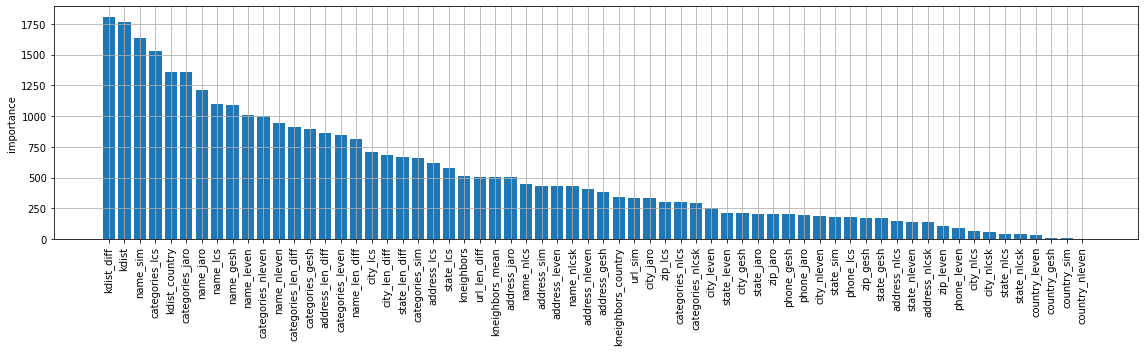

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

#Check CV

In [ ]:
test_data = add_features(test_data)
pred = inference_lgb(models, test_data[features])
test_data['pred'] = pred[:, 1]

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
def post_process(df):
    id2match = dict(zip(df['id'].values, df['matches'].str.split()))

    for base, match in df[['id', 'matches']].values:
        match = match.split()
        if len(match) == 1:        
            continue

        for m in match:
            if base not in id2match[m]:
                id2match[m].append(base)
    df['matches'] = df['id'].map(id2match).map(' '.join)
    return df 

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    test_pred_df = test_data[test_data['pred'] > x][['id', 'match_id']]
    out_df = pd.DataFrame()
    out_df['id'] = test_data['id'].unique().tolist()
    out_df['match_id'] = out_df['id']
    out_df = pd.concat([out_df, test_pred_df])
    out_df = out_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
    out_df = post_process(out_df)

    score = get_score(out_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-06-04 15:27:19,096] A new study created in memory with name: no-name-9e27a716-4d05-4fe7-ad2a-94b619e71717
[I 2022-06-04 15:28:01,188] Trial 0 finished with value: 0.8035300319250727 and parameters: {'threshold': 0.22728352972308552}. Best is trial 0 with value: 0.8035300319250727.


CV: 0.803530


[I 2022-06-04 15:28:22,410] Trial 1 finished with value: 0.8296045061099807 and parameters: {'threshold': 0.4926880737134276}. Best is trial 1 with value: 0.8296045061099807.


CV: 0.829605


[I 2022-06-04 15:28:43,148] Trial 2 finished with value: 0.7983188024144409 and parameters: {'threshold': 0.8783066381792878}. Best is trial 1 with value: 0.8296045061099807.


CV: 0.798319


[I 2022-06-04 15:29:03,334] Trial 3 finished with value: 0.8199880029080605 and parameters: {'threshold': 0.7693230080263639}. Best is trial 1 with value: 0.8296045061099807.


CV: 0.819988


[I 2022-06-04 15:29:25,132] Trial 4 finished with value: 0.8293618313449204 and parameters: {'threshold': 0.4843755205962914}. Best is trial 1 with value: 0.8296045061099807.


CV: 0.829362


[I 2022-06-04 15:29:47,880] Trial 5 finished with value: 0.752202252199358 and parameters: {'threshold': 0.09350827075622148}. Best is trial 1 with value: 0.8296045061099807.


CV: 0.752202


[I 2022-06-04 15:30:08,508] Trial 6 finished with value: 0.7812821988037605 and parameters: {'threshold': 0.9207352883471652}. Best is trial 1 with value: 0.8296045061099807.


CV: 0.781282


[I 2022-06-04 15:30:29,738] Trial 7 finished with value: 0.8252273023789979 and parameters: {'threshold': 0.7157956536284791}. Best is trial 1 with value: 0.8296045061099807.


CV: 0.825227


[I 2022-06-04 15:30:50,169] Trial 8 finished with value: 0.7853616869187124 and parameters: {'threshold': 0.9123717971479745}. Best is trial 1 with value: 0.8296045061099807.


CV: 0.785362


[I 2022-06-04 15:31:12,852] Trial 9 finished with value: 0.8100048647776363 and parameters: {'threshold': 0.26279439780412817}. Best is trial 1 with value: 0.8296045061099807.


CV: 0.810005


[I 2022-06-04 15:31:33,939] Trial 10 finished with value: 0.8300432134283869 and parameters: {'threshold': 0.5098118007155571}. Best is trial 10 with value: 0.8300432134283869.


CV: 0.830043


[I 2022-06-04 15:31:55,626] Trial 11 finished with value: 0.829935083003895 and parameters: {'threshold': 0.5060306845579126}. Best is trial 10 with value: 0.8300432134283869.


CV: 0.829935


[I 2022-06-04 15:32:16,286] Trial 12 finished with value: 0.8300493724124005 and parameters: {'threshold': 0.6175588602900285}. Best is trial 12 with value: 0.8300493724124005.


CV: 0.830049


[I 2022-06-04 15:32:37,722] Trial 13 finished with value: 0.8298837715836863 and parameters: {'threshold': 0.6277478646358767}. Best is trial 12 with value: 0.8300493724124005.


CV: 0.829884


[I 2022-06-04 15:33:00,071] Trial 14 finished with value: 0.8191342943287542 and parameters: {'threshold': 0.327956128820995}. Best is trial 12 with value: 0.8300493724124005.


CV: 0.819134


[I 2022-06-04 15:33:20,484] Trial 15 finished with value: 0.8300583696833143 and parameters: {'threshold': 0.6174430944437285}. Best is trial 15 with value: 0.8300583696833143.


CV: 0.830058


[I 2022-06-04 15:33:41,615] Trial 16 finished with value: 0.8290530568934498 and parameters: {'threshold': 0.6509349984497602}. Best is trial 15 with value: 0.8300583696833143.


CV: 0.829053


[I 2022-06-04 15:34:03,814] Trial 17 finished with value: 0.8236912753410128 and parameters: {'threshold': 0.37857360837724197}. Best is trial 15 with value: 0.8300583696833143.


CV: 0.823691


[I 2022-06-04 15:34:23,745] Trial 18 finished with value: 0.8157314620098348 and parameters: {'threshold': 0.7996975295700042}. Best is trial 15 with value: 0.8300583696833143.


CV: 0.815731


[I 2022-06-04 15:34:43,183] Trial 19 finished with value: 0.6772640741227492 and parameters: {'threshold': 0.9969829001455182}. Best is trial 15 with value: 0.8300583696833143.


CV: 0.677264


[I 2022-06-04 15:35:04,022] Trial 20 finished with value: 0.8301528682630798 and parameters: {'threshold': 0.6077340763251046}. Best is trial 20 with value: 0.8301528682630798.


CV: 0.830153


[I 2022-06-04 15:35:25,335] Trial 21 finished with value: 0.8300519354919809 and parameters: {'threshold': 0.6165628290990314}. Best is trial 20 with value: 0.8301528682630798.


CV: 0.830052


[I 2022-06-04 15:35:46,795] Trial 22 finished with value: 0.8305216087145668 and parameters: {'threshold': 0.569844717325336}. Best is trial 22 with value: 0.8305216087145668.


CV: 0.830522


[I 2022-06-04 15:36:07,779] Trial 23 finished with value: 0.8258509499731973 and parameters: {'threshold': 0.4109226361353188}. Best is trial 22 with value: 0.8305216087145668.


CV: 0.825851


[I 2022-06-04 15:36:28,992] Trial 24 finished with value: 0.824701361488338 and parameters: {'threshold': 0.7226149435066347}. Best is trial 22 with value: 0.8305216087145668.


CV: 0.824701


[I 2022-06-04 15:36:50,953] Trial 25 finished with value: 0.8306320061407176 and parameters: {'threshold': 0.546542268558482}. Best is trial 25 with value: 0.8306320061407176.


CV: 0.830632


[I 2022-06-04 15:37:12,080] Trial 26 finished with value: 0.8305533952178354 and parameters: {'threshold': 0.5619090923725104}. Best is trial 25 with value: 0.8306320061407176.


CV: 0.830553


[I 2022-06-04 15:37:40,968] Trial 27 finished with value: 0.826884887216251 and parameters: {'threshold': 0.4259637392783231}. Best is trial 25 with value: 0.8306320061407176.


CV: 0.826885


[I 2022-06-04 15:38:02,551] Trial 28 finished with value: 0.8306131492715186 and parameters: {'threshold': 0.5493522342393735}. Best is trial 25 with value: 0.8306320061407176.


CV: 0.830613


[I 2022-06-04 15:38:26,030] Trial 29 finished with value: 0.772717353684718 and parameters: {'threshold': 0.12883712493865457}. Best is trial 25 with value: 0.8306320061407176.


CV: 0.772717


[I 2022-06-04 15:38:48,930] Trial 30 finished with value: 0.7938275118500816 and parameters: {'threshold': 0.18759098681939834}. Best is trial 25 with value: 0.8306320061407176.


CV: 0.793828


[I 2022-06-04 15:39:09,810] Trial 31 finished with value: 0.8305840609513612 and parameters: {'threshold': 0.5366878611451008}. Best is trial 25 with value: 0.8306320061407176.


CV: 0.830584


[I 2022-06-04 15:39:31,293] Trial 32 finished with value: 0.8306492164578801 and parameters: {'threshold': 0.5460831572189015}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.830649


[I 2022-06-04 15:39:52,321] Trial 33 finished with value: 0.8282477767828798 and parameters: {'threshold': 0.4523656351205408}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.828248


[I 2022-06-04 15:40:14,521] Trial 34 finished with value: 0.8201888155711907 and parameters: {'threshold': 0.33828926717679597}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.820189


[I 2022-06-04 15:40:36,136] Trial 35 finished with value: 0.8305451772995496 and parameters: {'threshold': 0.5346115843991824}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.830545


[I 2022-06-04 15:40:56,435] Trial 36 finished with value: 0.8269672638141835 and parameters: {'threshold': 0.692558477210877}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.826967


[I 2022-06-04 15:41:17,558] Trial 37 finished with value: 0.818668839074244 and parameters: {'threshold': 0.7794893777041298}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.818669


[I 2022-06-04 15:41:39,342] Trial 38 finished with value: 0.8287578698975557 and parameters: {'threshold': 0.46332176424752836}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.828758


[I 2022-06-04 15:42:00,212] Trial 39 finished with value: 0.8099950810690946 and parameters: {'threshold': 0.8320481674889477}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.809995


[I 2022-06-04 15:42:20,732] Trial 40 finished with value: 0.8274314734569183 and parameters: {'threshold': 0.6823410320885157}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.827431


[I 2022-06-04 15:42:42,347] Trial 41 finished with value: 0.8305638388755469 and parameters: {'threshold': 0.563362878343186}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.830564


[I 2022-06-04 15:43:04,057] Trial 42 finished with value: 0.8305677244945601 and parameters: {'threshold': 0.5667601694935549}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.830568


[I 2022-06-04 15:43:25,878] Trial 43 finished with value: 0.8293668089007259 and parameters: {'threshold': 0.4846259965992241}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.829367


[I 2022-06-04 15:43:46,436] Trial 44 finished with value: 0.8306337725284317 and parameters: {'threshold': 0.5416374220602874}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.830634


[I 2022-06-04 15:44:08,454] Trial 45 finished with value: 0.8236581737816739 and parameters: {'threshold': 0.3782062290289285}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.823658


[I 2022-06-04 15:44:29,326] Trial 46 finished with value: 0.8302411810599535 and parameters: {'threshold': 0.5189073349116776}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.830241


[I 2022-06-04 15:45:01,401] Trial 47 finished with value: 0.48853647889867785 and parameters: {'threshold': 0.006398229500058861}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.488536


[I 2022-06-04 15:45:22,706] Trial 48 finished with value: 0.8235270818497865 and parameters: {'threshold': 0.7363097425695698}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.823527


[I 2022-06-04 15:45:43,792] Trial 49 finished with value: 0.817178961446648 and parameters: {'threshold': 0.31131244808915703}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.817179


[I 2022-06-04 15:46:05,038] Trial 50 finished with value: 0.8280093766143798 and parameters: {'threshold': 0.6730097233745844}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.828009


[I 2022-06-04 15:46:26,752] Trial 51 finished with value: 0.8304667815976602 and parameters: {'threshold': 0.5859604852369289}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.830467


[I 2022-06-04 15:46:47,590] Trial 52 finished with value: 0.8301668056041052 and parameters: {'threshold': 0.5156633469785955}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.830167


[I 2022-06-04 15:47:09,259] Trial 53 finished with value: 0.8306255235511821 and parameters: {'threshold': 0.5484069671778807}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.830626


[I 2022-06-04 15:47:30,960] Trial 54 finished with value: 0.8287404798302032 and parameters: {'threshold': 0.4627935528633901}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.828740


[I 2022-06-04 15:48:00,856] Trial 55 finished with value: 0.8293292294285607 and parameters: {'threshold': 0.6460536039600857}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.829329


[I 2022-06-04 15:48:23,265] Trial 56 finished with value: 0.8304947829407318 and parameters: {'threshold': 0.5326035738088971}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.830495


[I 2022-06-04 15:48:45,349] Trial 57 finished with value: 0.8271808446290507 and parameters: {'threshold': 0.430657225174517}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.827181


[I 2022-06-04 15:49:06,519] Trial 58 finished with value: 0.8244287199953974 and parameters: {'threshold': 0.3891399169610744}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.824429


[I 2022-06-04 15:49:27,979] Trial 59 finished with value: 0.8294915281239913 and parameters: {'threshold': 0.4881553378614704}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.829492


[I 2022-06-04 15:49:49,316] Trial 60 finished with value: 0.8301549900242718 and parameters: {'threshold': 0.6091171421333184}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.830155


[I 2022-06-04 15:50:10,199] Trial 61 finished with value: 0.8306473117190877 and parameters: {'threshold': 0.5477384683509632}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.830647


[I 2022-06-04 15:50:31,762] Trial 62 finished with value: 0.8306439412609886 and parameters: {'threshold': 0.5469233198559824}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.830644


[I 2022-06-04 15:50:53,262] Trial 63 finished with value: 0.8304002059236235 and parameters: {'threshold': 0.5899377499371214}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.830400


[I 2022-06-04 15:51:13,650] Trial 64 finished with value: 0.8291199377301063 and parameters: {'threshold': 0.6501818057498021}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.829120


[I 2022-06-04 15:51:34,925] Trial 65 finished with value: 0.8305680926626683 and parameters: {'threshold': 0.5555928861907335}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.830568


[I 2022-06-04 15:51:56,458] Trial 66 finished with value: 0.8296101060032506 and parameters: {'threshold': 0.4928260549158976}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.829610


[I 2022-06-04 15:52:18,383] Trial 67 finished with value: 0.8281379063533878 and parameters: {'threshold': 0.4499840862551644}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.828138


[I 2022-06-04 15:52:38,921] Trial 68 finished with value: 0.8303443434546968 and parameters: {'threshold': 0.5979025302246329}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.830344


[I 2022-06-04 15:53:00,227] Trial 69 finished with value: 0.8294461444530359 and parameters: {'threshold': 0.6419612530009696}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.829446


[I 2022-06-04 15:53:20,870] Trial 70 finished with value: 0.8306341833826762 and parameters: {'threshold': 0.546406290782397}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.830634


[I 2022-06-04 15:53:42,268] Trial 71 finished with value: 0.8302137236770976 and parameters: {'threshold': 0.5176619212131629}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.830214


[I 2022-06-04 15:54:03,911] Trial 72 finished with value: 0.8306430473518268 and parameters: {'threshold': 0.5438806856083921}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.830643


[I 2022-06-04 15:54:24,468] Trial 73 finished with value: 0.8304671464675308 and parameters: {'threshold': 0.5810965987175957}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.830467


[I 2022-06-04 15:54:46,115] Trial 74 finished with value: 0.8297324791456121 and parameters: {'threshold': 0.49758878524556815}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.829732


[I 2022-06-04 15:55:07,622] Trial 75 finished with value: 0.8299961696261035 and parameters: {'threshold': 0.6201495387397749}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.829996


[I 2022-06-04 15:55:28,320] Trial 76 finished with value: 0.8306213158805806 and parameters: {'threshold': 0.5511930167421579}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.830621


[I 2022-06-04 15:55:49,971] Trial 77 finished with value: 0.8288317262866962 and parameters: {'threshold': 0.4658888863485601}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.828832


[I 2022-06-04 15:56:12,892] Trial 78 finished with value: 0.8273509392523546 and parameters: {'threshold': 0.4341242353113948}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.827351


[I 2022-06-04 15:56:35,208] Trial 79 finished with value: 0.8254386070510252 and parameters: {'threshold': 0.40417827202234935}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.825439


[I 2022-06-04 15:56:55,527] Trial 80 finished with value: 0.8276274645711634 and parameters: {'threshold': 0.6794812201359444}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.827627


[I 2022-06-04 15:57:17,161] Trial 81 finished with value: 0.8306443108149663 and parameters: {'threshold': 0.5438210756312377}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.830644


[I 2022-06-04 15:57:37,779] Trial 82 finished with value: 0.830519181496352 and parameters: {'threshold': 0.5338354639959367}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.830519


[I 2022-06-04 15:57:59,203] Trial 83 finished with value: 0.8305084700766752 and parameters: {'threshold': 0.5703721387915965}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.830508


[I 2022-06-04 15:58:25,663] Trial 84 finished with value: 0.8301944635941441 and parameters: {'threshold': 0.6043914291169653}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.830194


[I 2022-06-04 15:58:48,723] Trial 85 finished with value: 0.8299371618695465 and parameters: {'threshold': 0.5063576798667166}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.829937


[I 2022-06-04 15:59:11,037] Trial 86 finished with value: 0.8291336301686814 and parameters: {'threshold': 0.4769990853677477}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.829134


[I 2022-06-04 15:59:32,526] Trial 87 finished with value: 0.8297540304789706 and parameters: {'threshold': 0.6329308028450533}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.829754


[I 2022-06-04 15:59:53,645] Trial 88 finished with value: 0.8305934977743197 and parameters: {'threshold': 0.5384037598457577}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.830593


[I 2022-06-04 16:00:15,909] Trial 89 finished with value: 0.8304953437162584 and parameters: {'threshold': 0.572448262180382}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.830495


[I 2022-06-04 16:00:37,469] Trial 90 finished with value: 0.8261977768467746 and parameters: {'threshold': 0.703652674373749}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.826198


[I 2022-06-04 16:00:59,288] Trial 91 finished with value: 0.8306265093811279 and parameters: {'threshold': 0.5512242733264946}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.830627


[I 2022-06-04 16:01:20,515] Trial 92 finished with value: 0.8301251045777351 and parameters: {'threshold': 0.5139348152176513}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.830125


[I 2022-06-04 16:01:42,326] Trial 93 finished with value: 0.830642862694313 and parameters: {'threshold': 0.5430931336807541}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.830643


[I 2022-06-04 16:02:03,118] Trial 94 finished with value: 0.8304165191353969 and parameters: {'threshold': 0.589237311904618}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.830417


[I 2022-06-04 16:02:24,569] Trial 95 finished with value: 0.8283520977971228 and parameters: {'threshold': 0.6659312308651216}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.828352


[I 2022-06-04 16:02:46,471] Trial 96 finished with value: 0.830375693456466 and parameters: {'threshold': 0.5235529517141227}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.830376


[I 2022-06-04 16:03:07,687] Trial 97 finished with value: 0.8296442672831025 and parameters: {'threshold': 0.4939222523868846}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.829644


[I 2022-06-04 16:03:29,481] Trial 98 finished with value: 0.8279366623721728 and parameters: {'threshold': 0.4452998939987882}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.827937


[I 2022-06-04 16:03:51,413] Trial 99 finished with value: 0.8291096787848471 and parameters: {'threshold': 0.4757178056398121}. Best is trial 32 with value: 0.8306492164578801.


CV: 0.829110


In [ ]:
threshold = study.best_params['threshold']
threshold

0.5460831572189015

In [ ]:
study.best_value

0.8306492164578801

In [ ]:
test_pred_df = test_data[test_data['pred'] > threshold][['id', 'match_id']]
out_df = pd.DataFrame()
out_df['id'] = test_data['id'].unique().tolist()
out_df['match_id'] = out_df['id']
out_df = pd.concat([out_df, test_pred_df])
out_df = out_df.groupby('id')['match_id'].\
                    apply(list).reset_index()
out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
out_df = post_process(out_df)

score = get_score(out_df)
print(f"CV: {score:.6f}")

CV: 0.830649


# 間違っているものの中身を見る

In [ ]:
data = data.reset_index()

labelが1なのに0と予測しているもの

In [ ]:
false_negative = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] <= threshold), :]
false_negative.describe()

,kdist,kneighbors,fold,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,141724.000000,141724.000000,137683.000000,137683.000000,137683.000000,132841.000000,145677.000000,147119.0,147119.000000,147119.000000,...,147119.000000,147115.000000,147115.000000,147115.000000,147115.000000,147119.000000,147115.000000,147115.000000,147115.000000,1.471190e+05
mean,0.005720,6.272466,6.954504,0.003404,6.283419,0.417317,6.556787,1.0,0.260065,0.409172,...,0.999028,0.999099,0.001842,0.999082,1.998199,0.000027,0.000921,0.999099,0.999099,2.087760e-01
std,0.036014,5.243504,1.427776,0.018160,5.247298,2.378208,5.308793,0.0,0.310778,0.253441,...,0.031162,0.029741,0.060502,0.030204,0.059483,0.005214,0.030251,0.029741,0.029741,1.708604e-01
min,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.440672e-07
25%,0.000453,2.000000,6.000000,0.000343,2.000000,0.005959,2.000000,1.0,0.000000,0.200000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,4.821680e-02
50%,0.001148,4.000000,7.000000,0.000888,5.000000,0.054708,5.000000,1.0,0.000000,0.387097,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.736763e-01
75%,0.003104,10.000000,8.000000,0.002435,10.000000,0.313440,10.000000,1.0,0.508172,0.588235,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,3.545683e-01
max,1.849236,19.000000,9.000000,1.109099,19.000000,170.784270,19.000000,1.0,1.000000,1.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,5.460828e-01


In [ ]:
false_negative.sample(min(false_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,fold,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
900678,E_94bfe0ebb7f7af,E_b072a7a80f8371,0.000288,1.0,P_e12848d1685635,7.0,0.000252,1.0,1.446037e-01,1.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.237662
2672844,E_b16a931b248693,E_cca2f3bc13dc52,0.000669,4.0,P_07a0ca854ee940,6.0,0.000131,2.0,4.103335e+00,3.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.540341
1571703,E_c2694128598290,E_e0bf6fc4905471,0.000452,2.0,P_e87f9e9e1b808e,7.0,0.000451,2.0,2.786328e-03,2.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.008332
7533235,E_3ad6dc100ada3b,E_969a11062d862e,0.006214,13.0,P_8abbe7c4debf04,8.0,0.006127,13.0,1.423599e-02,13.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.386328
771198,E_5ab0e54a3a4b5c,E_5ad41f7d043c28,0.000408,1.0,P_fb2121c7595aed,5.0,0.000274,1.0,4.889993e-01,1.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.506826
1485223,E_9b8ec25a8bccd9,E_b2c60281f54ef4,0.000373,2.0,P_0ba792ef1e0860,6.0,0.000279,1.0,3.375015e-01,1.5,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.135372
1387840,E_6ffeb3417e47f3,E_db4897b0b2a0f6,0.000185,2.0,P_c54f4b0494f271,9.0,0.000181,2.0,2.160033e-02,2.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.458844
9057144,E_e7f8dfb1261475,E_64c47f72cb1f7c,0.000554,15.0,P_7c5f67c96b0d53,5.0,0.000552,15.0,4.143088e-03,15.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.222465
10422172,E_4dbe39d0655f05,E_71061ab0593a21,0.000184,18.0,P_9a9134572d445b,5.0,0.000171,18.0,7.464543e-02,18.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.146897
721923,E_44864912d37ce5,E_2cd321d717dd41,0.000650,1.0,P_b3136f1fe77e2f,5.0,0.000650,1.0,2.761357e-04,1.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.124274


In [ ]:
for id, match_id in false_negative.sample(min(false_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
818589,E_b7d5b947e0aae1,Tesco Express,51.515299,-0.097053,14-16 St Martin's-Le-Grand,London,Greater London,EC2V 6BJ,GB,http://www.tesco.com/store-locator/uk/,+443456719511,Grocery Stores,P_7227629c1af27d,2,8.0
1031055,E_e7a7c726a535de,Tesco Bank,51.514954,-0.094154,NaN,NaN,NaN,NaN,GB,NaN,NaN,Banks,P_7227629c1af27d,2,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
547722,E_7b1b271d68cb2f,kamar 2304 Gd. maria 3,-6.893719,107.613617,NaN,NaN,NaN,NaN,ID,NaN,NaN,Hospitals,P_be0e106ddb0831,4,9.0
1017844,E_e4ae0539b9cc59,Gedung Maria Lantai 3 Kamar 2303 - RS.Borromeu...,-6.894165,107.613734,NaN,Bandung,West Java,NaN,ID,NaN,NaN,Hospitals,P_be0e106ddb0831,4,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
93239,E_14e6ed13a6c827,Лимонный зал,43.570208,39.733405,"Черноморская, 3",Сочи,NaN,NaN,RU,NaN,NaN,Event Spaces,P_4f2d7f51450773,4,6.0
981756,E_dc8b79f733c701,Lounge Grazia,43.571119,39.731968,NaN,NaN,NaN,NaN,RU,NaN,NaN,Public Art,P_4f2d7f51450773,4,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
765121,E_abde198bd83c79,Ruang ICU RS permata bunda,3.580613,98.685473,Jl. Sisingamangaraja.,NaN,NaN,NaN,ID,NaN,NaN,Emergency Rooms,P_9010f093bc3950,4,5.0
1002072,E_e11af039ebcf70,RS Permata Bunda Intan A Lt.2,3.580806,98.685645,NaN,NaN,NaN,NaN,ID,NaN,NaN,Hospitals,P_9010f093bc3950,4,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
517176,E_743e4459d41ebd,Clb stedelijk onderwijs gent,51.044864,3.707961,NaN,Gent,NaN,9000,BE,NaN,NaN,"College Administrative Buildings, Medical Centers",P_8ea4ba667e8dc7,1,8.0
533063,E_77ccd53e281937,Interstedelijk Centrum voor Leerlingenbegeleid...,51.045152,3.708023,Jubileumlaan 215,Gent,NaN,9000,BE,http://iclb.be,+3293235300,Offices,P_8ea4ba667e8dc7,1,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
203220,E_2d98418feae29f,寿賀喜屋,35.353454,136.932421,NaN,NaN,NaN,NaN,JP,NaN,NaN,Asian Restaurants,P_577b0a7d01cb4f,1,6.0
1111209,E_f9c6a455b3307b,寿がきや ZENT扶桑店,35.353358,136.932470,高雄突田1,丹羽郡扶桑町,愛知県,480-0102,JP,NaN,+81587929264,Ramen Restaurants,P_577b0a7d01cb4f,1,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
427154,E_5ffbe85f6b489e,Кабинет Истории Сибирского лицея,56.465195,84.972587,"Усова,56",NaN,NaN,NaN,RU,NaN,NaN,NaN,P_600db893362a7a,4,6.0
707706,E_9ef4ee92934367,Приемная Сибирского Лицея,56.464118,84.972233,"Усова,56",NaN,NaN,NaN,RU,NaN,NaN,NaN,P_600db893362a7a,4,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
236611,E_351ec7cc5bf654,拉合爾印度巴基斯坦料理,22.622537,120.316593,NaN,NaN,NaN,NaN,TW,NaN,NaN,Indian Restaurants,P_6ad63602a59308,1,6.0
761251,E_ab034b7c154e4a,LaHore 拉合爾異國美食 Indian and Pakistani Curry,22.622681,120.317093,NaN,Kaohsiung,NaN,NaN,TW,NaN,NaN,"Indian Restaurants, Pakistani Restaurants, Hal...",P_6ad63602a59308,1,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
209548,E_2f0784612781b2,Кабинет Географии,55.725887,37.565238,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Academic Buildings,P_25f96e813a6a28,4,9.0
961611,E_d8048771740979,Лекционный зал. Лучивая Диагностика.,55.725973,37.566129,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Auditoriums,P_25f96e813a6a28,4,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
905205,E_cb577e36aed811,ジュノン,35.706677,139.617401,上荻1-23-1,杉並区,東京都,167-0043,JP,NaN,0333986121,Yoshoku Restaurants,P_074827f11c5f8f,1,6.0
1062983,E_eee70fa862c324,Junon,35.706676,139.617320,NaN,杉並区,東京都,167-0043,JP,NaN,NaN,Tea Rooms,P_074827f11c5f8f,1,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
503124,E_712154f491bb10,Пляж У Финского Залива,59.860320,30.16310,NaN,NaN,NaN,NaN,RU,NaN,NaN,Beaches,P_a5119fd465dfb0,4,9.0
721807,E_a2236404a7ffa2,Набережная Финского залива,59.869168,30.15727,Берег Финского залива,Санкт- Петербург,St.-Petersburg,NaN,RU,NaN,NaN,"Waterfronts, Scenic Lookouts",P_a5119fd465dfb0,4,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
600079,E_86def96786a248,disney on ice @ Oracle Arena,37.750271,-122.202812,NaN,Oakland,CA,94621,US,NaN,NaN,General Entertainment,P_a6e05c1c514af3,4,7.0
1058246,E_edd0c0e45db923,Row 10 section 128,37.750214,-122.202697,NaN,Oakland,CA,NaN,US,NaN,NaN,Basketball Courts,P_a6e05c1c514af3,4,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
10268,E_0256217e66b8ec,Limite Vertical,19.332316,-99.060071,NaN,NaN,NaN,NaN,MX,NaN,NaN,Indie Movie Theaters,P_9a9134572d445b,4,5.0
986192,E_dd8d6cd0e1fcc7,Hollow Man,19.332311,-99.060085,NaN,NaN,NaN,NaN,MX,NaN,NaN,Indie Movie Theaters,P_9a9134572d445b,4,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
133138,E_1dd652d984a8af,Muthana Complex,29.366385,47.967654,Fahad Al Salem St,Kuwait City,Kuwait,NaN,KW,NaN,NaN,"Shopping Malls, Bookstores, Thai Restaurants",P_90c9366dc533ae,2,6.0
460009,E_675b186109083e,ALMUTHANNA,29.366047,47.968616,الصالحية,NaN,NaN,NaN,KW,NaN,NaN,Shopping Malls,P_90c9366dc533ae,2,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
404026,E_5ac953af83bf44,Lotus # พระราม4,13.718544,100.568807,NaN,NaN,NaN,NaN,TH,NaN,NaN,Department Stores,P_ac707cabac99c6,4,6.0
528021,E_76a6dc0a2ac61c,Tesco Lotus Extra (เทสโก้ โลตัส เอ็กซ์ตร้า),13.717441,100.568344,3300 Rama IV Rd.,Khlong Toei,Bangkok,10110,TH,http://www.tescolotus.com,26728585,Big Box Stores,P_ac707cabac99c6,4,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
622933,E_8c0e1151b1e777,ikeaaa,51.023875,3.688314,NaN,NaN,NaN,NaN,BE,NaN,NaN,Furniture / Home Stores,P_1c0c18bb5a8c56,4,5.0
1072415,E_f104a40587182f,Ikea Gent,51.029691,3.689112,NaN,NaN,NaN,NaN,BE,NaN,NaN,Furniture / Home Stores,P_1c0c18bb5a8c56,4,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
495521,E_6f6155f16019b0,Кабинет Информатики 💻💾,56.513151,85.036529,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Classrooms,P_9ccaebe4aee7cd,3,9.0
622551,E_8bf6edb0246a57,Урок Черчение,56.512781,85.035949,NaN,NaN,NaN,NaN,RU,NaN,NaN,Middle Schools,P_9ccaebe4aee7cd,3,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
360336,E_50f9015d502e78,Кафедра Истории И Философии,47.227838,39.740268,"пер.Нахичеванский, 29",Ростов-на-Дону,NaN,NaN,RU,NaN,NaN,Medical Schools,P_7e9ac07989be98,4,9.0
1043685,E_ea8200d392be13,УЛК ростгму,47.228547,39.740430,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Academic Buildings,P_7e9ac07989be98,4,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
164715,E_24eb4e3d555e65,bursa otogar,40.267721,29.052064,NaN,NaN,NaN,NaN,TR,NaN,NaN,Bus Stations,P_6682c14d7b0904,4,8.0
232773,E_343ea9250d6912,Bursa Sehırlerarası Otobus Termınalı,40.266717,29.052502,NaN,NaN,NaN,NaN,TR,NaN,NaN,NaN,P_6682c14d7b0904,4,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
258038,E_39ef591a5bec56,Nysa Antik Kent,37.885781,28.143706,Sultanhisar,NaN,NaN,NaN,TR,NaN,NaN,Historic Sites,P_6ee9874aee8eee,4,8.0
830529,E_ba8197e5fccef5,nysaa harebeleri,37.903542,28.147320,NaN,NaN,NaN,NaN,TR,NaN,NaN,Historic Sites,P_6ee9874aee8eee,4,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
337445,E_4bd8ab223503ac,"McD/McCafe Sarinah, Jakarta Pusat",-6.187120,106.822818,SARINAH,"SARINAH, Jakarta Pusat",NaN,NaN,ID,NaN,NaN,Breakfast Spots,P_e186e4f44acd41,4,9.0
1107220,E_f8dcaacbe33f8a,Mc'D sarinah,-6.187436,106.822455,Jakarta Pusat,NaN,NaN,NaN,ID,NaN,NaN,American Restaurants,P_e186e4f44acd41,4,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
158242,E_2374785204bb32,İç İşleri Bakanlığı,39.914531,32.854068,NaN,NaN,NaN,NaN,TR,NaN,NaN,"Housing Developments, Government Buildings",P_1278442e363225,4,5.0
601715,E_87389c5255ffb0,T.C. İçişleri Bakanlığı İller İdaresi Genel Mü...,39.914284,32.852700,NaN,NaN,NaN,NaN,TR,NaN,NaN,Government Buildings,P_1278442e363225,4,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
768933,E_acb614c2404c6d,淘宝街（zhengyi Mall),25.042473,102.708230,NaN,NaN,NaN,NaN,CN,NaN,NaN,Gift Shops,P_f1fa81a219809c,2,7.0
837763,E_bc20bb8d6aff96,正义坊购物中心,25.042907,102.709217,正义路100号,昆明,云南,NaN,CN,NaN,87168369369,Shopping Malls,P_f1fa81a219809c,2,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
864625,E_c237a481abbd80,Starbucks connaught,3.080625,101.733541,NaN,NaN,NaN,NaN,MY,NaN,NaN,Coffee Shops,P_90c03df76893ac,3,9.0
1061446,E_ee8c4dd0ce8dd6,Starbucks Coffee,3.080576,101.733398,NaN,NaN,NaN,NaN,MY,NaN,NaN,Coffee Shops,P_90c03df76893ac,3,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
82993,E_12933eb2070b31,Batutulis Resto Aston Bogor,-6.636518,106.794903,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_112d4dda29d6f2,4,7.0
163349,E_249c99f475e5a3,Lounge Hotel Aston & Resort,-6.638640,106.805575,Near the Jungle - nirwana residence,Bogor,NaN,NaN,ID,NaN,NaN,Hotel Bars,P_112d4dda29d6f2,4,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
354178,E_4f97e2f70634c1,Mama's Foods @ The Food Court,40.758706,-73.988900,8th Avenue,New York,NY,10001,US,NaN,NaN,Food Courts,P_7104f85997ae4a,1,7.0
1068566,E_f02a78ddc6cf61,Mama’s Pizza,40.758736,-73.988866,705 8th Ave,New York,NY,10036,US,NaN,2129563400,Pizza Places,P_7104f85997ae4a,1,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
570808,E_80505d0ea703c1,マイシスター小栗有以レーン,34.636575,135.420109,NaN,NaN,NaN,NaN,JP,NaN,NaN,Mental Health Offices,P_e8d0f8cdfe18fc,3,7.0
1046418,E_eb219dbe08db1b,高倉萌香 レーン,34.636525,135.418145,NaN,大阪市,大阪府,559-0034,JP,NaN,NaN,"Conventions, Festivals, Parades",P_e8d0f8cdfe18fc,3,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
3440,E_00cc3ffab4a66b,Kuramathi - The Palm Restaurant,4.258977,72.976237,NaN,NaN,North Central Province,NaN,MV,NaN,NaN,Italian Restaurants,P_5ca54fe3f3c554,1,5.0
1013592,E_e3b7cf18aca1ad,Palm Pizzeria,4.259905,72.984922,Kuramathi Island Resort,NaN,NaN,NaN,MV,NaN,NaN,Pizza Places,P_5ca54fe3f3c554,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
63219,E_0e27213afab391,コクーン1 (COCOON 1),35.89490,139.636076,大宮区吉敷町4-267-2,さいたま市,埼玉県,330-9559,JP,NaN,486015050,Shopping Malls,P_48700178479565,1,5.0
90092,E_14306ee2756402,コクーン1 北館,35.89645,139.635450,大宮区吉敷町4-263-1,さいたま市,埼玉県,330-0843,JP,NaN,NaN,Shopping Malls,P_48700178479565,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
286470,E_40507479cf6998,Гуманитарная гимназия № 8,64.569107,39.841219,"ул. Торцева, 12",Северодвинск,NaN,164520,RU,http://school8.edu.severodvinsk.ru,+78184561716,"Schools, College Math Buildings",P_86afa420d32d95,4,9.0
352126,E_4f20efff2dc931,"Библиотека, 8 гг",64.569374,39.841507,NaN,NaN,NaN,NaN,RU,NaN,NaN,Universities,P_86afa420d32d95,4,9.0


labelが0なのに1と予測しているもの

In [ ]:
false_positive = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] > threshold), :]
false_positive.describe()

,kdist,kneighbors,fold,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,59379.000000,59379.000000,57654.000000,57654.000000,57654.000000,55890.000000,60625.000000,61296.0,61296.000000,61296.000000,...,61296.000000,61296.000000,61296.000000,61296.000000,61296.000000,61296.0,61296.000000,61296.000000,61296.000000,61296.000000
mean,0.007823,4.634770,6.987963,0.003429,4.658809,0.398109,4.904948,0.0,0.578000,0.611313,...,0.997781,0.997895,0.004437,0.997781,1.995791,0.0,0.002219,0.997895,0.997895,0.740218
std,0.196697,4.854896,1.418082,0.019999,4.865858,1.458710,4.988409,0.0,0.354275,0.247759,...,0.047052,0.045200,0.094103,0.047052,0.090400,0.0,0.047052,0.045200,0.045200,0.128373
min,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.546085
25%,0.000317,1.000000,6.000000,0.000238,1.000000,0.006991,1.000000,0.0,0.331405,0.444444,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.626909
50%,0.000897,2.000000,7.000000,0.000695,2.000000,0.061152,2.500000,0.0,0.651101,0.628571,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.725484
75%,0.003039,7.000000,8.000000,0.002293,7.000000,0.317741,7.000000,0.0,0.880450,0.800000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.845156
max,43.801057,19.000000,9.000000,1.928752,19.000000,66.758956,19.000000,0.0,1.000000,1.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,0.0,1.000000,1.000000,1.000000,0.999986


In [ ]:
false_positive.sample(min(false_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,fold,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
728464,E_477b5b0a73dfcf,E_7ff21c22a11164,0.009485,1.0,P_baf6fff97de607,6.0,0.004945,1.0,0.918217,1.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.609490
787063,E_61da9ec3ca902c,E_bb2f54e5cd9268,0.000143,1.0,P_40de986ae8f9be,5.0,0.000143,1.0,0.000004,1.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.894449
4302409,E_8e4987dd671b78,E_f512fc218a8594,0.007974,7.0,P_ce2715fa7c8369,9.0,0.006187,8.0,0.288700,7.5,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.567776
947736,E_a9dc316b5dd791,E_ceedd296d581f5,0.000030,1.0,P_9443be1b444882,8.0,0.000020,1.0,0.466506,1.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.984212
2440843,E_49655dd04e2064,E_7df3da2733f5c0,0.018731,4.0,P_be211af518195d,8.0,0.018521,5.0,0.011310,4.5,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.657352
9857624,E_4ff2b2d9badea9,E_79b9a3308a098b,0.001759,17.0,P_7f169303300574,5.0,0.001108,15.0,0.587388,16.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.570551
1137816,E_ff8b4543b5669f,E_a31a5b6a41acf7,0.000412,1.0,P_fae274b7ec9287,7.0,0.000324,1.0,0.268710,1.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.785377
10993458,E_4e95c618a588ec,E_0ac8b0ac50d8a1,0.004646,19.0,P_ec0179a86099bc,6.0,0.004585,19.0,0.013377,19.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.802420
640758,E_2000f62edfdda3,E_e6223e177e0b73,0.000384,1.0,P_1cf0d9ec7f23ca,8.0,0.000381,4.0,0.008564,2.5,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.664662
775426,E_5c9feb73e391e4,E_7df052bcd8f5e1,0.000167,1.0,P_0335c41515e35c,7.0,0.000100,1.0,0.671596,1.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.774545


In [ ]:
for id, match_id in false_positive.sample(min(false_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
414858,E_5d357bc8cd3db2,cafe table terrace (カフェテーブルテラス),35.662832,139.709723,神宮前5-51-8,渋谷区,東京都,150-0001,JP,NaN,0364279677,Cafés,P_083152830a553d,1,9.0
1077423,E_f21f589f9bd28c,Marcer cafe,35.663227,139.709614,NaN,NaN,NaN,NaN,JP,NaN,NaN,Cafés,P_b50305f60b5c7a,1,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
318234,E_4785145b907c7b,oma sänky,60.432650,22.251381,NaN,NaN,NaN,NaN,FI,NaN,NaN,"Bed & Breakfasts, American Restaurants",P_eb3f9c160d9188,0,7.0
1060654,E_ee5c56b3d95f2f,oma sänky,60.417227,22.260539,NaN,NaN,NaN,NaN,FI,NaN,NaN,Residential Buildings (Apartments / Condos),P_52ca63ca53b8fb,0,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
560261,E_7deb3fad790e53,東京駅 夜行バス チケットうりば,35.682201,139.770285,丸の内1-9-1,Chiyoda,Tōkyō,100-0005,JP,NaN,NaN,Bus Stations,P_51996178844683,4,7.0
636532,E_8f1aca729f3da4,東京駅 3番バスのりば,35.682219,139.769818,丸の内1-9-1,Chiyoda,Tōkyō,100-0005,JP,NaN,NaN,Bus Stations,P_4b1c7c2f90b913,0,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
574628,E_812a810f0f7162,Topkapı Sarayı Harem Dairesi,41.012604,28.983789,"Cankurtaran, Topkapı Sarayı, Fatih",Fatih,Türkiye,34122,TR,https://muze.gen.tr/muze-detay/harem,+902125120480,History Museums,P_5c7770402ed74e,1,5.0
637160,E_8f3e7594d935e7,Topkapı Sarayı Müzesi,41.010871,28.981834,Cankurtaran,Istanbul,Istanbul,34122,TR,https://muze.gen.tr/muze-detay/topkapi,2125120480,"History Museums, Palaces",P_7506e922e4719a,4,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
203778,E_2db9dda31dfb6f,Pilot Travel Centers,36.643213,-83.700365,NaN,Middlesborough,KY,40965,US,NaN,NaN,Gas Stations,P_ab2225364afc16,1,8.0
328900,E_49eef2a7d3a48a,Pilot Travel Centers,36.722082,-84.168062,481 West Highway 92,Williamsburg,KY,40769,US,https://locations.pilotflyingj.com/us/ky/willi...,6065490162,"Gas Stations, Convenience Stores",P_e9b8ff0dec6976,1,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
852268,E_bf660a6c4ed40c,Shiseido @ Takashimaya,1.303088,103.835747,NaN,NaN,NaN,NaN,SG,NaN,NaN,Cosmetics Shops,P_1657a3b8e31c63,0,7.0
1018694,E_e4df25e50fdbc2,EA @ Takashimya,1.303158,103.835071,NaN,NaN,NaN,NaN,SG,NaN,NaN,Cosmetics Shops,P_bbfad509b8c265,0,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
750996,E_a8b6f7700e1c76,Aula N308,18.806347,-99.221437,NaN,NaN,NaN,NaN,MX,NaN,NaN,College Classrooms,P_d9510ac0ea92b3,0,6.0
1079502,E_f296893d6fc8d0,Aula N407,18.806295,-99.221567,NaN,NaN,NaN,NaN,MX,http://www.cva.itesm.mx,NaN,College Classrooms,P_9fc6ea33e7222e,0,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
533650,E_77eea399218f13,Çanakkale Devlet Hastanesi Kalp-Damar,40.149169,26.408338,NaN,NaN,NaN,NaN,TR,NaN,NaN,Hospitals,P_b640fb84ba2619,0,7.0
1028916,E_e72b5d0c4deca5,Çanakkale Devlet Hastanesi Akbank Bankamatiği,40.149503,26.408142,NaN,NaN,NaN,NaN,TR,NaN,NaN,Hospitals,P_6f432b03e86230,0,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
394953,E_58c05da5ffe641,JR 新横浜駅 (JR Shin-Yokohama Sta.),35.507075,139.617615,港北区篠原町2937,横浜市,神奈川県,222-0026,JP,https://www.jreast.co.jp,NaN,Train Stations,P_a38c350571627d,2,7.0
898520,E_c9d5e63c61d76f,新横浜駅 西のりかえ口,35.507100,139.617321,篠原町2937,横浜市港北区,神奈川県,NaN,JP,NaN,NaN,Train Stations,P_12fc25ebfda2c0,0,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
541530,E_79ae1086917b9a,Żabka,52.249797,20.990095,NaN,Warszawa,Mazowieckie,00-168,PL,NaN,NaN,"Grocery Stores, Convenience Stores, Food & Dri...",P_03f8d41bf8cab7,0,9.0
837159,E_bc00271f60f1b0,Żabka,52.253866,20.985472,Dzika,NaN,NaN,NaN,PL,NaN,NaN,"Markets, Convenience Stores",P_275b49157e046e,0,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
534336,E_7814a6401eb696,Baggage Claim 2,42.947595,-87.902603,MKE Airport,Milwaukee,WI,NaN,US,NaN,NaN,Baggage Claims,P_4caec61a99cfb8,0,6.0
1039986,E_e9a86ccbaad61d,Baggage Claim,42.947819,-87.902551,MKE Airport,Milwaukee,WI,53207,US,NaN,NaN,Baggage Claims,P_efbbb068721fea,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
1035809,E_e8b98d61a37ce0,bradley center section 225,43.043714,-87.917112,NaN,Milwaukee,WI,53205,US,NaN,NaN,Stadiums,P_c97732a0787536,4,9.0
1069614,E_f0655f138e4712,Bradley Center Section 212,43.043828,-87.917054,2000-2098 Wisconsin 32,Milwaukee,WI,53202,US,NaN,NaN,"Hockey Arenas, Basketball Stadiums",P_eced2871ebd6e7,0,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
71018,E_0fe32f2bd0f563,อาคาร 4 ก.วน.ธท.,13.719880,100.587026,NaN,Bangkok,NaN,NaN,TH,NaN,NaN,Schools,P_5a6331b335d1ad,0,9.0
808263,E_b58342187391df,อาคาร 1 ก.วน.ธท.,13.719595,100.586360,NaN,Bangkok,NaN,NaN,TH,NaN,NaN,Schools,P_f910aa5e224646,0,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
720515,E_a1da5dba828e4d,China Inn,19.351713,-99.186312,Insurgentes Sur 1971,Distrito Federal,NaN,NaN,MX,NaN,NaN,Chinese Restaurants,P_5fe8dc9764ae8b,1,9.0
939117,E_d2edb76915fe01,China Inn,19.352427,-99.185608,NaN,NaN,NaN,NaN,MX,NaN,NaN,Chinese Restaurants,P_0e7f4f62333782,1,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
16865,E_03d12015c3ee90,Tepe Prime,39.908977,32.755076,NaN,NaN,NaN,NaN,TR,NaN,NaN,NaN,P_44cb8d6b8a8982,1,5.0
68519,E_0f54801c69a47e,Newcastle Tepe Prime,39.908601,32.755501,NaN,NaN,NaN,NaN,TR,NaN,NaN,Bars,P_8c98ee9a65efe0,2,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
681375,E_9910f1e00c455e,İzmir 21. İcra Müdürlüğü,38.448861,27.175085,NaN,NaN,NaN,NaN,TR,NaN,NaN,Courthouses,P_379397dc89a09f,0,6.0
774573,E_adfb4cc502540c,İzmir 21. Asliye Ceza Mahkemesi,38.449317,27.174551,NaN,NaN,NaN,NaN,TR,NaN,NaN,Courthouses,P_04852e3634bcc6,0,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
151385,E_21f04af4335816,ท่าเทียบเรือดอนสัก,9.328707,99.744522,สุราษฎร์ธานี,NaN,NaN,NaN,TH,NaN,NaN,Boats or Ferries,P_02b5ea9addd4d5,1,6.0
419348,E_5e352a06becb4c,ท่าเทียบเรืออเนกประสงค์ดอนสัก,9.337722,99.681216,NaN,Don Sak,Surat Thani,NaN,TH,NaN,NaN,NaN,P_45829ddc969dd4,1,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
86817,E_137175967e1fe1,Palimanan-cirebon,-6.701888,108.496986,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_e973efba4d9eba,0,5.0
986789,E_ddb00dbe053924,"Amazy, Palimanan, cirebon",-6.707890,108.432928,Palimanan,Cirebon,Jawa barat,NaN,ID,NaN,NaN,NaN,P_10da7c9a66b662,0,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
63698,E_0e417b8cebd3b0,Günbatımı Konutları Parkı,37.974824,34.669517,NaN,NaN,NaN,NaN,TR,NaN,NaN,Gardens,P_f9c2695243b670,0,5.0
441143,E_632359edb32db9,Günbatımı Konutları,37.975965,34.671537,NaN,NaN,NaN,NaN,TR,NaN,NaN,Coffee Shops,P_a42cbd93033168,0,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
640816,E_900e537603e366,"НИУ ИТМО, аудитория 412",59.956202,30.309904,"Кронверкский просп., 49",NaN,NaN,NaN,RU,http://www.ifmo.ru,NaN,College Auditoriums,P_0f6f8bc5fb993a,1,8.0
1115705,E_fad1fc8dd818d7,ЦДО,59.956394,30.309473,"Кронверкский пр., 49",NaN,NaN,NaN,RU,NaN,NaN,College Auditoriums,P_9b643634269881,1,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
1071650,E_f0d714ff7c08fe,Керемет,42.830319,74.584186,Пр. Мира,Бишкек,NaN,NaN,KG,NaN,NaN,Residential Buildings (Apartments / Condos),P_34ebf4ffcf8b5b,0,5.0
1110198,E_f98b0f0f5f6e91,"""ТСЖ\""Керемет-Элит\"", пр. Мира 237 А-Б""",42.830609,74.584071,NaN,NaN,Пр. Мира 237 А Б,NaN,KG,NaN,NaN,Housing Developments,P_b3192b24667389,0,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
525217,E_760486b9d2aa83,Hazal Kuyumculuk,36.889303,30.695916,Güllük Cad.40/E,Antalya,Antalya,07040,TR,http://hazaljewelry.com,2422434423,Jewelry Stores,P_47614cc7c1cced,0,7.0
729779,E_a3ef7088e004f0,Adalı kuyumculuk,36.889349,30.695673,NaN,NaN,NaN,NaN,TR,NaN,NaN,Jewelry Stores,P_d9e09b9f2120cd,0,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
1002386,E_e12b625a144168,SMAN 8 Denpasar,-8.598409,115.223129,Jalan Antasura Kaja,Denpasar,Bali,80233,ID,http://www.sman8denpasar.sch.id,3619008200,"High Schools, Buildings, Student Centers",P_f70bff77640cc3,1,6.0
1104829,E_f855e098648b09,XII IPA 5 - SMAN 8 DENPASAR,-8.598367,115.223064,Peguyangan,NaN,NaN,NaN,ID,NaN,NaN,College Classrooms,P_9104c266287fa8,0,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
472476,E_6a2ff04f36ff96,İstanbul Anadolu 17. Aile Mahkemesi,40.914516,29.178383,NaN,NaN,NaN,NaN,TR,NaN,NaN,Courthouses,P_8120b7e4c4c6fd,0,6.0
1083551,E_f37de5a2279fd7,Anadolu 54.Asliye Ceza Mahkemesi Duruşma Salonu,40.916306,29.177292,NaN,NaN,NaN,NaN,TR,NaN,NaN,Courthouses,P_a39f7fd7757d72,0,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
322581,E_4886b057d69a41,A & T Jewellery,41.010202,28.971803,NaN,NaN,NaN,NaN,TR,NaN,NaN,Jewelry Stores,P_afc4e572d167b7,0,7.0
791317,E_b1bb24c8a80afc,Beyza Kuyumculuk,41.010708,28.972528,NaN,NaN,NaN,NaN,TR,NaN,NaN,Jewelry Stores,P_cdb0cec2dbb5a2,0,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
485860,E_6d2fbd7db58e12,Splash And Dash Car Wash,19.389585,-99.084208,NaN,NaN,NaN,NaN,MX,NaN,NaN,"Automotive Shops, Car Washes",P_5df0695476cccb,1,5.0
1059745,E_ee27db6ec48520,Auto Lavado Stop & Go,19.389460,-99.084164,NaN,Ciudad de México,CDMX,09030,MX,NaN,NaN,Car Washes,P_c95df65a506fdf,0,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
572501,E_80af6f54e651b2,Labranda Mares Theatre,36.823597,28.243000,Labranda Mares Marmaris,Marmaris,Ichmeler,NaN,TR,NaN,NaN,NaN,P_213a5707f14810,1,8.0
1046904,E_eb3e81de6cc26c,Mares Teras,36.823358,28.243106,NaN,NaN,NaN,NaN,TR,NaN,NaN,Vineyards,P_4d7ad742bbb158,0,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
113745,E_197df0f2f43816,Dunman High School,1.298745,103.882544,10 Tanjong Rhu Rd,Singapore,NaN,436895,SG,http://www.dhs.sg/,63450533,"High Schools, College Classrooms, College Gyms",P_0f37f74aea0e53,1,7.0
1103426,E_f80448c1c48a7f,Dunman High GSL,1.300280,103.883318,NaN,NaN,NaN,NaN,SG,NaN,NaN,NaN,P_283d564e148a2c,0,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
635533,E_8ee1ae3f9d7667,Café Nordstrom,47.612351,-122.335785,500 Pine St,Seattle,WA,98101,US,https://www.nordstrom.com/store-details/nordst...,+12066282111,Cafés,P_8789b65fa5daee,1,5.0
1040651,E_e9d0aadbeb090d,Nordstrom,47.612364,-122.335727,500 Pine St,Seattle,WA,98101,US,https://www.nordstrom.com/store-details/nordst...,2066282111,Women's Stores,P_5a7c5a28944fa0,1,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
130777,E_1d51b818f2e36b,PU Buje,45.408611,13.657807,NaN,NaN,NaN,NaN,HR,NaN,NaN,Military Bases,P_c2089ecda6afd0,0,9.0
141288,E_1fa9063de6854b,POU Buje,45.408749,13.658697,NaN,NaN,NaN,NaN,HR,NaN,NaN,Movie Theaters,P_c5af8d5f41f3c9,0,7.0


labelが1で1と予測しているもの

In [ ]:
true_positive = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] > threshold), :]
true_positive.describe()

,kdist,kneighbors,fold,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,857523.000000,857523.000000,849962.000000,849962.000000,849962.000000,272157.000000,859651.000000,867189.0,867189.000000,867189.000000,...,867189.000000,867181.000000,867181.000000,867181.000000,867181.000000,867189.0,867181.000000,867181.000000,867181.000000,867189.000000
mean,0.001470,1.035948,6.996792,0.000784,1.037137,0.426968,1.099304,1.0,0.817303,0.910788,...,0.999441,0.999539,0.001012,0.999494,1.999079,0.0,0.000506,0.999539,0.999539,0.960893
std,0.015894,2.672188,1.413985,0.006027,2.692764,1.859445,2.781191,0.0,0.348589,0.195640,...,0.023642,0.020908,0.044962,0.022474,0.041815,0.0,0.022481,0.020908,0.020908,0.090660
min,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.546094
25%,0.000000,0.000000,6.000000,0.000000,0.000000,0.007774,0.000000,1.0,0.828492,1.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.983003
50%,0.000000,0.000000,7.000000,0.000000,0.000000,0.069017,0.000000,1.0,1.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.999971
75%,0.000211,1.000000,8.000000,0.000153,1.000000,0.338300,1.000000,1.0,1.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.999988
max,4.246996,19.000000,9.000000,1.396027,19.000000,225.865403,19.000000,1.0,1.000000,1.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,0.0,1.000000,1.000000,1.000000,1.000000


In [ ]:
true_positive.sample(min(true_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,fold,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
357524,E_a07d6761e187f8,E_a07d6761e187f8,0.000000,0.0,P_32e63879412474,6.0,0.000000,0.0,NaN,0.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999989
497748,E_dfa6d326720b13,E_dfa6d326720b13,0.000000,0.0,P_bbe2573ef4b5d0,8.0,0.000000,0.0,NaN,0.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999990
65297,E_1d5123766d80f3,E_1d5123766d80f3,0.000000,0.0,P_ef4aabe53de673,7.0,0.000000,0.0,NaN,0.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999986
123546,E_3764517bcba0f6,E_3764517bcba0f6,0.000000,0.0,P_967a8234937856,5.0,0.000000,0.0,NaN,0.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999980
731188,E_48bd2cce6a309c,E_ac732e0f95cf38,0.003776,1.0,P_61133244d9f4ab,6.0,0.003739,1.0,0.010006,1.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.996399
464279,E_d095d0abb36318,E_d095d0abb36318,0.000000,0.0,P_e73c6c7c3e4fa3,7.0,0.000000,0.0,NaN,0.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999993
450200,E_ca3045c5cb1095,E_ca3045c5cb1095,0.000000,0.0,P_cc79d16a004e07,9.0,0.000000,0.0,NaN,0.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999794
342872,E_99ef430e12caa5,E_99ef430e12caa5,0.000000,0.0,P_502e1e8ff886d9,5.0,0.000000,0.0,NaN,0.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999944
48618,E_15cf84537fc66c,E_15cf84537fc66c,0.000000,0.0,P_0ce0630ec75348,5.0,0.000000,0.0,NaN,0.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999995
315239,E_8da4090e7e7f09,E_8da4090e7e7f09,0.000000,0.0,P_d8647fc656bebe,5.0,0.000000,0.0,NaN,0.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999942


In [ ]:
for id, match_id in true_positive.sample(min(true_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
600799,E_8706e6098ec467,Rancatore's,42.447263,-71.227222,1752 Massachusetts Ave,Lexington,MA,02420,US,http://www.rancs.com/,7818625090,Ice Cream Shops,P_a7cc86571afb1a,0,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
448611,E_64d1524ff48469,Lubar S195,43.075891,-87.882473,UWM,Milwaukee,WI,53211,US,NaN,NaN,College Classrooms,P_e518a96a4d332f,0,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
505589,E_71ae65b46da108,Goodwill Royal Palm Beach Store & Donation Center,26.691020,-80.197060,9920 Belevdere Rd,Royal Palm Beach,FL,33411,US,http://www.gulfstreamgoodwill.com/goodwill-ret...,+15617842830,Thrift / Vintage Stores,P_1a2789c2acc652,1,5.0
639996,E_8fe1b055367c1f,Goodwill,26.690882,-80.197267,NaN,West Palm Beach,FL,33411,US,NaN,NaN,Thrift / Vintage Stores,P_1a2789c2acc652,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
130386,E_1d3ce289091b62,創成川通り北八条横断歩道橋,43.070961,141.354550,北8条西1〜東1丁目,札幌市北区・東区,北海道,060-0808,JP,NaN,NaN,Bridges,P_d4f91ec662708d,1,5.0
976714,E_db69b88c259ca2,創成川通北8条歩道橋,43.070982,141.354294,北区北8条西1〜東区東1,札幌市,北海道,NaN,JP,NaN,NaN,Bridges,P_d4f91ec662708d,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
407265,E_5b86a2d90b9998,sephora,26.307625,50.168991,NaN,NaN,NaN,NaN,SA,NaN,NaN,NaN,P_18e8c5d6be07be,1,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
206176,E_2e43bf282d5936,Eec Index Changhua,24.081505,120.540769,NaN,NaN,NaN,NaN,TW,NaN,NaN,NaN,P_39c1a107037fdb,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
315692,E_46f1d77202279a,Safeway Pharmacy,39.483474,-105.074946,NaN,Littleton,CO,NaN,US,NaN,NaN,NaN,P_df749f60351eba,1,9.0
757300,E_aa1f54db0812c2,Safeway,39.483473,-105.075221,8355 N Rampart Range Rd,Littleton,CO,80125,US,https://local.safeway.com/safeway/co/littleton...,3032423563,"Grocery Stores, Supermarkets",P_df749f60351eba,1,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
568570,E_7fcee2ad21792f,ゆうちょ銀行 ATM,35.770118,139.797625,NaN,足立区,東京都,123-0851,JP,NaN,NaN,Banks,P_75806670d85ea6,2,5.0
886121,E_c706896b7a7ea0,ゆうちょ銀行 ATM,35.769924,139.797498,NaN,足立区,東京都,123-0851,JP,NaN,NaN,Banks,P_75806670d85ea6,2,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
856679,E_c066ebdc5f8e96,مسجد حميد الطاير,25.153096,55.20204,جميرا,Dubai,NaN,NaN,AE,NaN,NaN,Mosques,P_26fc7477adc957,1,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
204088,E_2dcc2c8cf3104f,Çeşme Marina,38.321030,26.300627,Çeşme,NaN,Çeşme,NaN,TR,NaN,NaN,"Harbors / Marinas, Piers",P_a990e4553eb587,1,6.0
1029570,E_e75123379672f4,Çeşme Marina,38.319893,26.298853,NaN,İzmir,Çeşme,NaN,TR,NaN,NaN,Piers,P_a990e4553eb587,1,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
687085,E_9a5070cb7c61ea,Graha Sumantri,-7.219578,108.190361,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_9bc2d63a1324f3,4,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
422660,E_5ef4c6b30ea5d4,Warung bandeng tanpa duri,-8.114541,112.575590,Jl raya kebonagung,Pakisaji,East Java,NaN,ID,NaN,NaN,Diners,P_61423f1f39f9d9,1,5.0
1026778,E_e6b43bd9e78bd4,Bandeng tanpa duri,-8.114589,112.575679,Ngadilangkung Kepanjen,NaN,NaN,NaN,ID,NaN,NaN,Diners,P_61423f1f39f9d9,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
337080,E_4bc26c76655f2d,東口駐車場 [沖縄県総合運動公園],26.310314,127.82723,NaN,沖縄市,沖縄県,904-2173,JP,NaN,NaN,Parking,P_549ff42c1187d6,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
153582,E_226af3d4c9d2ae,VFW,44.641422,-93.255266,NaN,Lakeville,MN,NaN,US,NaN,NaN,Bars,P_b96e3e602985c0,2,7.0
588007,E_842c181dd83bdc,Lakeville VFW Post 210,44.647750,-93.243786,8790 Upper 208th St W,lakeville,MN,55044,US,NaN,9524695717,"Veterans' Organizations, Social Clubs, Bars",P_b96e3e602985c0,2,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
41333,E_093e3f16a64971,Funke Mediengruppe,51.447185,7.001617,NaN,Essen,North Rhine-Westphalia,NaN,DE,NaN,NaN,NaN,P_71b9ecd72847b6,2,8.0
298006,E_42eb401d51eba8,Funke Mediengruppe,51.448427,7.002081,Friedrichstr. 34-38,Essen,NRW,45128,DE,http://www.funkemedien.de,+498006060760,Offices,P_71b9ecd72847b6,2,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
509572,E_728fc179834ec6,Леруа Мерлен,55.729201,37.734292,"Рязанский просп., 2, корп. 2",Москва,Москва,109052,RU,https://leroymerlin.ru,+78007000099,Hardware Stores,P_a0b76c68895a72,2,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
445874,E_6435db5f022466,Marco Polo Airport,45.453436,12.29942,NaN,NaN,Venice,NaN,IT,NaN,NaN,Airports,P_053c2915ad7d58,3,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
969031,E_d9aca0d8ffca73,佐多岬,31.009454,130.668836,NaN,肝属郡南大隅町,鹿児島県,893-2604,JP,NaN,NaN,NaN,P_693b460c105aae,1,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
217656,E_30e11febdc304d,General Shale,34.754324,-86.712556,7029 Highway 72 W,Huntsville,AL,35806,US,NaN,+12568378685,Miscellaneous Shops,P_c6e82690345cfd,1,8.0
797313,E_b31223c47084fa,General Shale Brick,34.753539,-86.710386,7029 University Drive Northwest,Huntsville,AL,35806,US,https://generalshale.com,+12568378685,NaN,P_c6e82690345cfd,1,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
88460,E_13d3766cc5083f,Автомойка,59.938,30.370665,"8-я Советская ул., 4",Санкт-Петербург,NaN,NaN,RU,NaN,NaN,Car Washes,P_4b55e91a1e41d6,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
372022,E_539801ee7849ab,Applied Biosystems,37.569599,-122.269501,850 Lincoln Centre Dr,Foster City,CA,94404,US,NaN,NaN,Offices,P_a87367dae5a9f0,0,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
768246,E_ac905cd866ec5e,Eskişehir 3. Aile Mahkemesi,39.767818,30.53471,NaN,NaN,NaN,NaN,TR,NaN,NaN,Courthouses,P_0043b95957c858,1,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
339159,E_4c3a41bf1adbf5,SINGER SAINT MÉDARD EN JALLES,44.879031,-0.688869,6 Avenue de Berlincan,Saint-Médard-en-Jalles,Nouvelle-Aquitaine,33160,FR,https://singerlesparre.business.site,+33681829151,Electronics Stores,P_66a9a4520dc7de,0,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
999629,E_e08cb31f3a46d8,Paulinho Lanches,-21.770024,-52.112256,"R. Maceio, 6-83",Presidente Epitácio,SP,19470-000,BR,NaN,1832812096,"Hot Dog Joints, Burger Joints, Snack Places",P_f3bc688bd7384f,1,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
274328,E_3d9893a7d5b01e,AA Hotel Bali,-8.734927,115.16587,Jl.Kartika Plaza Gg.Samudra No.100X Tuban,Bali,Bali,NaN,ID,NaN,NaN,Motels,P_921ae04aa68256,0,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
95280,E_155d12dd4427e5,Kawasan Industri Surya Cipta,-6.38489,107.334452,Jalan Surya Lestari,Karawang,Indonesia,41361,ID,http://www.suryacipta.com,+62276440088,"Factories, Offices, Buildings",P_6da54f18b7f6db,1,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
276599,E_3e1689de368a9d,Waffle Sokağı,37.188522,40.59554,Waffle Sokağı,Mardin,Kızıltepe,47400,TR,NaN,NaN,Cafés,P_707842b301131b,1,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
4185,E_00f6fd04559492,Starbucks (Wall Centre),49.280247,-123.127266,1088 Burrard St,Vancouver,NaN,NaN,CA,NaN,NaN,Coffee Shops,P_5867fcf204458a,1,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
1128749,E_fdb7ed223835ab,Kepez Balkon,36.949760,30.631694,NaN,Antalya,Antalya,NaN,TR,NaN,NaN,Scenic Lookouts,P_9041c08cbfad2a,3,9.0
1130722,E_fe2c9e41750cb6,Kepez varyant,36.950226,30.631840,NaN,NaN,NaN,NaN,TR,NaN,NaN,Scenic Lookouts,P_9041c08cbfad2a,3,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
211889,E_2f91d5ee456c93,Lob moom restaurant ร้านหลบมุม เมี่ยงปลาเผา,14.357158,100.571786,NaN,NaN,NaN,NaN,TH,NaN,NaN,Asian Restaurants,P_562db1242f4162,1,9.0


labelが0で0と予測しているもの

In [ ]:
true_negative = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] <= threshold), :]
true_negative.describe()

,kdist,kneighbors,fold,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,1.032923e+07,1.032923e+07,1.033702e+07,1.033702e+07,1.033702e+07,7.799841e+06,1.285941e+07,14072538.0,1.407254e+07,1.407254e+07,...,1.407254e+07,1.407236e+07,1.407236e+07,1.407236e+07,1.407236e+07,1.407254e+07,1.407236e+07,1.407236e+07,1.407236e+07,1.407254e+07
mean,4.612990e-02,1.027493e+01,7.000924e+00,1.736110e-02,1.026350e+01,4.234400e-01,1.078212e+01,0.0,1.024413e-01,2.618340e-01,...,9.943497e-01,9.945791e-01,1.100348e-02,9.945441e-01,1.989158e+00,8.314065e-06,5.501740e-03,9.945791e-01,9.945791e-01,7.776098e-03
std,3.139907e-01,5.359589e+00,1.414010e+00,5.731420e-02,5.364332e+00,2.722322e+00,5.236434e+00,0.0,2.899259e-01,2.567318e-01,...,7.495579e-02,7.267957e-02,1.470066e-01,7.324653e-02,1.453591e-01,2.883400e-03,7.350332e-02,7.267957e-02,7.267957e-02,3.812871e-02
min,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.568056e-12
25%,2.049907e-03,6.000000e+00,6.000000e+00,1.495590e-03,6.000000e+00,5.521402e-03,6.500000e+00,0.0,0.000000e+00,1.176471e-01,...,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.324399e-05
50%,6.065059e-03,1.000000e+01,7.000000e+00,4.399723e-03,1.000000e+01,5.785352e-02,1.100000e+01,0.0,0.000000e+00,2.000000e-01,...,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.786556e-04
75%,2.126926e-02,1.500000e+01,8.000000e+00,1.295089e-02,1.500000e+01,3.205486e-01,1.500000e+01,0.0,0.000000e+00,2.857143e-01,...,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.451385e-03
max,6.694559e+01,1.900000e+01,9.000000e+00,2.820613e+00,1.900000e+01,1.969534e+03,1.900000e+01,0.0,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.460787e-01


In [ ]:
true_negative.sample(min(true_negative.shape[0], 30))

In [ ]:
for id, match_id in true_negative.sample(min(true_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
551449,E_7bf1ce7a6cda47,Pos Polisi,-6.946578,107.659669,Jalan Margahayu Raya Barat,Bandung,West Java,NaN,ID,NaN,NaN,Buildings,P_48adf8c33b0fa9,0,6.0
1021360,E_e5780cc0f17d43,SD Tulus Kartika,-6.948700,107.662207,Jln rancabolang,Bandung,West Java,40286,ID,NaN,NaN,NaN,P_6f911ce47acbe4,0,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
11843,E_02b188e0cbe4d7,CVS Pharmacy,42.501708,-71.070027,451 Main St,Wakefield,MA,01880,US,NaN,NaN,"Pharmacies, Drugstores",P_38f3d6f195b78b,2,6.0
158217,E_23733bc64484c8,Redbox,36.042105,-86.743933,5531 Edmondson Pike,Nashville,TN,37211,US,http://www.redbox.com/locations/tennessee/nash...,8667332693,Video Stores,P_5f7ce8645bf16b,0,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
762484,E_ab497b94177ac0,Super Girl a-Go-Go,12.926525,100.873710,Soi Diamond,Pattaya,Chonburi,20150,TH,NaN,+66967540102,Strip Clubs,P_7f8e969d35a2ba,0,6.0
870244,E_c37d2937ac662a,Fascino South Pattaya,12.925266,100.876406,NaN,NaN,NaN,NaN,TH,NaN,NaN,Pharmacies,P_9979bc8793190c,0,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
695269,E_9c2b3e9ae79e11,Penske Truck Rental & Leasing,42.381424,-83.431239,13933 Eckles Rd,Plymouth,MI,48170,US,http://m.pensketruckrental.com,+17344510860,Travel & Transport,P_c989b0ad7c5d30,1,5.0
926698,E_d0275187a0086e,Sams Pharmacy,36.100411,-95.906013,NaN,Tulsa,OK,74145,US,NaN,NaN,"Medical Centers, Big Box Stores, Pharmacies",P_22bda051966d5b,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
517875,E_7467114f7a460b,Afros,39.795000,19.810149,NaN,Θιναλίου,Ionian Islands,NaN,GR,NaN,NaN,Seafood Restaurants,P_20c24197135b21,0,7.0
1092676,E_f5947bd46c1fb4,The Pumphouse,39.791902,19.816399,Acharavi,Θιναλίου,Κέρκυρα,NaN,GR,http://www.pumphousecorfu.com,2663063271,Greek Restaurants,P_686fc18409ef0c,1,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
1270,E_004cd72c9ddcdb,Holiday Inn Express & Suites,32.432414,-87.057381,2000 Lincoln Way,Selma,AL,36701,US,https://www.ihg.com/holidayinnexpress/hotels/u...,3348741000,"Hotels, Event Spaces, Meeting Rooms",P_ebad8e3bc944eb,1,5.0
463512,E_6822bc1ae6ea24,Charter Spectrum,32.407212,-87.032050,501 King St,Selma,AL,36701,US,NaN,(334) 247-9297,Business Services,P_31966fda1f9491,1,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
984818,E_dd3e1408937049,エネオス 芝野石油 西の茶屋給油所,34.970793,135.726375,NaN,NaN,NaN,NaN,JP,NaN,NaN,Gas Stations,P_38d225e85e4fea,1,9.0
1093097,E_f5abfc602db8a5,わくわく広場 イオンモール京都桂川店,34.963533,135.708587,南区久世高田町376-1,京都市,京都府,601-8601,JP,http://wakuwaku-hiroba.com/crazy_pantry.html,+81753237821,"Food & Drink Shops, Organic Groceries",P_bca78d8c4b99d7,1,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
672623,E_971993f4a938f8,Dunluce Castle,55.212310,-6.575179,87 Dunluce Rd,Bushmills,Northern Ireland,BT57 8UY,GB,NaN,2820731938,"Castles, Scenic Lookouts",P_2265d24e3ead88,1,5.0
788629,E_b123aa69f618e0,SPAR,54.505088,-3.545885,NaN,Egremont,Cumbria,NaN,GB,https://www.spar.co.uk,NaN,"Convenience Stores, Lottery Retailers",P_390779c5392537,1,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
613409,E_89e76bff803209,B&M Store,53.716814,-1.856715,Shay Syke,Halifax,West Yorkshire,HX1 2ND,GB,https://www.bmstores.co.uk,01422322585,"Discount Stores, Garden Centers",P_01a9771c5db7a5,1,5.0
940821,E_d3514c80ea0eed,Bull Green Car Park,53.721479,-1.863044,NaN,NaN,NaN,NaN,GB,NaN,NaN,Parking,P_ed69377f7521d3,0,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
458953,E_6722d30cd0e3e2,Alsancak Gratis,38.440721,27.143945,NaN,NaN,NaN,NaN,TR,NaN,NaN,NaN,P_38bbe7d78fc448,2,5.0
872856,E_c40ec4b96bdbc9,Black & White,38.439944,27.144424,1479 Sokak No: 20/B,Izmir,NaN,35220,TR,NaN,05357025757,Salons / Barbershops,P_1115ef63a0f4d4,0,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
631834,E_8e120a8b064842,Giant Eagle Supermarket,39.418975,-77.448065,1275 W Patrick St,Frederick,MD,21702,US,http://www.gianteagle.com,3016688712,"Supermarkets, Grocery Stores",P_ebc677fd60dda0,1,6.0
1043211,E_ea64f368d183d2,Parking Deck By Brewer Alley,39.415393,-77.410288,NaN,Frederick,MD,21701,US,NaN,NaN,Parking,P_dd5f8036018843,1,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
663236,E_9504883ae2bd89,"Block 38, The Quintet",1.398295,103.750701,NaN,NaN,NaN,NaN,SG,NaN,NaN,NaN,P_f4f1b50b5f74a6,0,8.0
1104635,E_f84a35063834c9,Blk 640 Choa Chu Kang North 6,1.398438,103.749607,Blk 640 Choa Chu Kang North 6,NaN,NaN,NaN,SG,NaN,NaN,Housing Developments,P_7ac5f9244e1798,0,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
240788,E_360e2cf3b1c3e6,Wyndham Building 10,36.218545,-86.704208,NaN,Nashville,TN,37214,US,NaN,NaN,Hotels,P_af6e0f859f1ad9,3,7.0
779699,E_af1fed353fd156,Comcast,36.218048,-86.698000,NaN,NaN,NaN,NaN,US,NaN,NaN,Coworking Spaces,P_8080facaccff1f,1,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
820540,E_b845b8972dd387,Caffé,-33.882296,151.220127,Boundary Street,Paddington,New South Wales,NaN,AU,NaN,NaN,NaN,P_7b29ea7126ddfd,0,9.0
917450,E_ce15791eb46795,Barefoot Yoga,-33.882802,151.220157,T3 Verona St,Paddington,NSW,2021,AU,http://www.barefootyoga.com.au,404693993,Yoga Studios,P_dd097a19a3a9bc,0,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
883012,E_c654bf3b4b79a9,Makmal Rangkaian 1 FTMK UTeM,2.307562,102.31867,NaN,NaN,NaN,NaN,MY,NaN,NaN,College Labs,P_4790172e6d53b3,0,7.0
1052961,E_ec96ea56e27861,SJK (C) Machap Baru,2.380264,102.32785,"1, Jalan Sekolah",Alor Gajah,Melaka,78000,MY,NaN,NaN,Schools,P_640570d402d53e,1,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
87314,E_138e8816eec723,Port Charlotte Town Center Mall,27.038419,-82.124803,1441 Tamiami Trl,Port Charlotte,FL,33948,US,NaN,9416244833,Shopping Malls,P_142b4feabe14f4,2,8.0
1017081,E_e480e40cec9a38,Strut n' Rut Archery,39.600915,-75.801135,410 Maloney Rd,Elkton,MD,21921,US,NaN,NaN,Sporting Goods Shops,P_394555034964b8,1,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
555222,E_7cc66e6d3adafe,Hotel Setiabudi,-7.632949,111.523881,NaN,Madiun,East Java,NaN,ID,NaN,NaN,Hotels,P_97d833e7c39bfd,1,6.0
967728,E_d9628799d2c6fe,Pasaraya Sri Ratu Madiun,-7.626877,111.521244,Jl.Pahlawan,Madiun,East Java,NaN,ID,NaN,NaN,Department Stores,P_527f1f1892dc4c,4,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
268717,E_3c59acc273e35a,KeyBank ATM,44.83500,-68.745404,NaN,Bangor,ME,04401,US,http://www.key.com,NaN,Banks,P_fcb77b6a7d76ff,1,9.0
390136,E_57a47384fd611a,EMCC - Maine Hall,44.82606,-68.743741,236-274 Sylvan Rd,Bangor,ME,04401,US,NaN,NaN,College Academic Buildings,P_b7d227f47862e1,0,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
13946,E_032773060fc052,Сквер возле Гасу,59.914154,30.313658,NaN,NaN,NaN,NaN,RU,NaN,NaN,NaN,P_5ec85e16ad6fb1,1,8.0
45146,E_0a1c801f2f5a40,Ст. метро Нарвская,59.910884,30.314216,NaN,NaN,NaN,NaN,RU,NaN,NaN,Metro Stations,P_b070b59f19eaa1,4,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
221486,E_31c02367826416,Yıldızlı TOKİ,40.992910,39.609489,Yıldızlı Beldesi,Trabzon,NaN,61310,TR,NaN,NaN,Housing Developments,P_8927727ce80eea,1,9.0
1130953,E_fe3a1cf3545c12,Şenol Güneş Spor Kompleksi Medical Park Stadyumu,41.000262,39.617645,Akyazı,Trabzon,NaN,NaN,TR,http://www.trabzonspor.org.tr,+904623250967,Soccer Stadiums,P_8d0f75c041d231,4,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
386954,E_56eee5651df4e1,MVP Physical Therapy,47.127494,-122.29260,14207 Meridian E,Puyallup,WA,98373,US,NaN,NaN,Physical Therapists,P_3127f593001643,0,6.0
485930,E_6d3384956851c2,Costco,47.156019,-122.30829,1201 39th Ave SW,Puyallup,WA,98373,US,https://www.costco.com,2534457543,Warehouse Stores,P_34ba134082ddee,0,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
337588,E_4bdf651f33197d,шоколаница,55.845780,37.660423,NaN,NaN,NaN,NaN,RU,NaN,NaN,Cafés,P_85e282bd6982f1,1,6.0
786511,E_b0ad79dcb571f6,Triumph,55.845771,37.660403,ТРЦ «Золотой Вавилон»,Москва,NaN,NaN,RU,NaN,NaN,Lingerie Stores,P_e1f00e48be70fa,0,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
231292,E_33ea687a74ec51,Market,43.279236,13.665876,S.S. 77 - Km. 104 + 378,62012 Civitanova Marche (MC),NaN,NaN,IT,http://www.vyaggio.com/location/273/Autogrill_...,NaN,Restaurants,P_5283cf3224e82e,0,5.0
820961,E_b85ae3ab834fc0,Supermercato Tigre,43.230251,13.624704,"Via Fermana Nord, 11",Montegranaro,NaN,63812,IT,NaN,0734890288,Grocery Stores,P_19be684937b60e,1,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
704743,E_9e4a56b510165b,Chacos,36.108118,-86.815453,NaN,Nashville,TN,37215,US,NaN,NaN,Shoe Stores,P_a664346c508486,0,8.0
949327,E_d53dc07564172f,Air Bar,36.147362,-115.155482,2000 Las Vegas Blvd S,Las Vegas,NV,89104,US,http://www.stratospherehotel.com/,7023807777,"Other Nightlife, Hotel Bars, Bars",P_0e45a77d6c910d,0,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
263313,E_3b210e7170d696,Ramada Cartersville,34.204790,-84.755765,45 Highway 20 Spur Se,Cartersville,GA,30121,US,NaN,NaN,Hotels,P_53775c59286f34,1,7.0
426469,E_5fd4785383605e,Love's Travel Stop,34.119133,-84.743179,150 Old Allatoona Rd Se,Emerson,GA,30121,US,https://www.loves.com/locations/359,7703824141,"Truck Stops, Gas Stations, Convenience Stores",P_ef88108677494f,1,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
950625,E_d589f1fc41741a,Days Inn,28.813039,-81.333745,4650 W State Road 46,Sanford,FL,32771,US,NaN,4073236500,"Hotels, Motels",P_a3d7910464bc5d,1,7.0
1008279,E_e279ea581430f9,Mckee Construction Co.,28.826196,-81.323021,790 Monroe Rd,Sanford,FL,32771,US,NaN,NaN,Coworking Spaces,P_4e4ef59086ebe9,1,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
372330,E_53a9ac66e1769d,에루화(냉면+떡갈비),35.837211,127.107541,대한민국 전라북도 전주시 완산구 서신동 936-5,전주시,전라북도,560-822,KR,NaN,NaN,Korean Restaurants,P_7f7e6b691f6be7,1,5.0
1004717,E_e1b1ef18e37c0c,Caffé bene,35.843547,127.126673,덕진구 명륜4길 17,전주시,전라북도,560-090,KR,http://www.caffebene.co.kr,NaN,"Cafés, Coffee Shops",P_ca5e2c9a06f7e3,1,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
911530,E_ccc5ae54aa9ca1,Mrs. Vastis's Room,34.153357,-81.199591,NaN,NaN,NaN,29063,US,NaN,NaN,College Classrooms,P_31bdc2e07d3bd8,0,7.0
933433,E_d1aa1953b290a5,PCC-IT International,34.140000,-118.890000,2629 Townsgate Rd Ste 235,Westlake Village,CA,91361,US,http://pccitint.com,+18447224846,NaN,P_884a98dc2199db,1,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
811456,E_b63b208a2da4bc,Padaria City Pão,-5.783681,-35.205630,"R. João Pessoa - Cidade Alta, Natal - RN, 5902...",Natal,RN,59025-500,BR,http://citypao.com.br,NaN,Bakeries,P_69e1378d9baed0,0,7.0
1111084,E_f9bf304f7696ce,CDF Colégio e Curso,-5.789622,-35.206349,R. Princesa Isabel,Natal,RN,NaN,BR,NaN,NaN,High Schools,P_fa8d886fe767ae,0,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
397535,E_595347cd97ffb7,Okinawa,47.107240,37.516968,NaN,Маріуполь,Донецька область,87500,UA,NaN,NaN,Sushi Restaurants,P_cf86b9a17f01b7,1,6.0
1125730,E_fd0ccdf5e36ba0,"""АТ \""ПУМБ\""""",47.069137,37.512103,"пр-т. Луніна, 11а",Маріуполь,NaN,87500,UA,http://www.pumb.ua,+380442907290,ATMs,P_4e238d893de557,0,7.0
